<a href="https://colab.research.google.com/github/dailerob/Queue-Network-prediction-using-GNNs/blob/main/Queueing_proj_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Queue Network Distributions with Gated Graph Convolutional Neural Networks
This is a project by Roberto Dailey, created final project for class ORI 390, Queueing. <br>
If you're new to colab, a **table of contents** is on the **upper left.** <br>
You can follow along and run the cells yourself in browser, or just read the output. <br>
NOTICE: the orignal model trained for about 20 hrs on a google TPU - you may want to avoid running the blocks for training. <br>
It contains classes for a queueing simulation as well as a Gated Graph Convolutional Network for predicting the distributions of the queueing simulation<br>

Most of the code was written directly by me, aside from some of the Gated Graph Convolutional Network classes and accompanying equations.<br>
Those were modified from this tutorial by Dr. Alfredo Canziani: https://www.youtube.com/watch?v=lWUh7jzhQ1Q&list=PLLHTzKZzVU9e6xUfG10TkTWApKSZCzuBI&index=24&t=2043s&ab_channel=AlfredoCanziani

You can check the corresponding paper I wrote for the class project here:


#Load in neccessary libraries/packages, load in graph drawing function

In [ ]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib
!pip3 install res

In [ ]:
!pip3 install pyblaze

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 3.6 MB/s 
     |████████████████████████████████| 22.3 MB 62.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [ ]:
#create the function set default

from matplotlib import pyplot as plt
import numpy as np
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['Solarize_Light2', 'bmh'])
    plt.rc('axes', facecolor='w')
    plt.rc('figure', facecolor='w')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep 26 18:53:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
test = np.array([])
np.sum(test)

0.0

In [ ]:
# import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import os
os.environ['DGLBACKEND'] = 'pytorch' #tell DGL what backend to use
import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time


import numpy as np
import networkx as nx
#from torch.res.plot_lib import set_default
import matplotlib.pyplot as plt

#import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

#Generate Synthetic Queueing Network Datasets

##Network Queue Simulation

###Queue Node Class

In [ ]:
#class to hold relevant information about an individual queue

#mu - service rate
#lam - affective arrival rate
#alpha - exterior arrival rate
#p_row - transition probabilities to other nodes (INCLUDING to outside of system)
#buffer_max - maximum size of the buffer
#node_id - which node this is
#BAS - "Block After Service" - implement blocking after service
class queue_node:
    #initialize properties of this queueing node
    def  __init__(self, mu, lam, alpha, p_row, buffer_max, node_id, BAS = True, verbose = False):
        self.node_id = node_id
        self.verbose = verbose
        self.BAS = BAS

        self.arrivals = []
        self.service_times = []
        self.deferral_times = []


        self.events = []
        self.event_type = []

        self.rand_arrivals = None
        self.rand_service = None
        self.rand_route = None

        self.hold = False
        self.hold_node = None

        self.mu = mu
        self.lam = lam
        self.alpha = alpha
        self.p_row = p_row
        self.buffer_max = buffer_max

        self.ticket_list = []

        self.buffer = 0

        #next arrival and buffer event
        self.active_times = np.array([np.inf, np.inf])

    #initialize the random arrival times, service times, and routing nodes for this queueing node
    def init_rand(self, num_steps):
        #start off with 1000
        self.rand_arrivals = list(np.random.exponential(1/self.alpha, 10))
        self.rand_service = list(np.random.exponential(1/self.mu, 10))
        self.rand_route = list(np.random.multinomial(1,self.p_row, 10).argmax(axis = 1))

        self.active_times[0] = self.rand_arrivals.pop()

    #update the time diff from an event
    #also use this as a chance to check if new RV's need to be generated
    def clock_update(self, diff):
        self.active_times -= diff

        rv_batch_size = 1000
        #check if there needs to be a new batch of arrival RV's
        if len(self.rand_arrivals) < rv_batch_size:
          self.rand_arrivals = self.rand_arrivals + list(np.random.exponential(1/self.alpha, rv_batch_size))

        #check if there needs to be a new batch of service RV's
        if len(self.rand_service) < rv_batch_size:
          self.rand_service = self.rand_service + list(np.random.exponential(1/self.mu, rv_batch_size))

        #check if there needs to be a new batch routing RV's
        if len(self.rand_route) < rv_batch_size:
          self.rand_route = self.rand_route + list(np.random.multinomial(1,self.p_row, rv_batch_size).argmax(axis = 1))

    #find nearest event time and return it
    def place_min(self):
        return min(self.active_times)

    #action when the event is an exterior arrival
    def arrival_action(self, clock):
        if self.verbose == True:
            print('arrival action for node ' + str(self.node_id))

        if self.buffer < self.buffer_max: #arrival that can be accepted
            self.buffer+=1
            self.events.append(clock)
            self.event_type.append(1)
            self.active_times[0] = self.rand_arrivals.pop()
            if self.buffer == 1 and self.hold == False:
                self.active_times[1] = self.rand_service.pop() #new service time starts

        else: #arrival that ca not be accepted
            self.active_times[0] = self.rand_arrivals.pop() #new arrival on way
            self.deferral_times.append(clock)

    #action when the event is a service
    def service_action(self, clock, buffers, buffer_sizes):
        if self.verbose == True:
            print('service action for node ' + str(self.node_id))

        new_node = self.rand_route.pop()
        self.events.append(clock)
        self.event_type.append(-1)

        self.buffer-=1
        if new_node < len(buffers):#case where item not routed out of sytem
            if buffers[new_node] < buffer_sizes[new_node] or new_node == self.node_id:
                if self.buffer > 0:
                    if len(self.ticket_list) == 0:#dont want to double count here
                        self.active_times[1] = self.rand_service.pop()
                else:
                    self.active_times[1] = np.inf

            else: #recieve queue is full
                if not(self.BAS): #if we discard routes to full buffers, we start the next service
                    if self.buffer > 0:
                        self.active_times[1] = self.rand_service.pop()
                    else:
                        self.active_times[1] = np.inf
                else:
                    self.buffer+=1
                    if self.verbose == True:
                        print('node ' + str(new_node) + ' is full, node ' + str(self.node_id) + ' now blocked')
                    self.active_times[1] = np.inf
                    self.hold = True

            return new_node #if we route to a node return the node routed to

        else: #item sent out of system
            if self.buffer==0: #there are no more items waiting
                self.active_times[1] = np.inf

            else:
                self.active_times[1] = self.rand_service.pop()

            return None

    #action function
    def action(self, buffers, buffer_sizes, clock):
        if self.verbose == True:
            print('action for node ' + str(self.node_id))

        if np.argmin(self.active_times) == 0:
            self.arrival_action(clock)
            return None
        else:
            return self.service_action(clock, buffers, buffer_sizes)

    #process incoming jobs
    def process_routing(self, node, clock):

        if self.buffer == self.buffer_max:
            if not(self.BAS):
                self.deferral_times.append(clock)
            else:
                self.ticket_list.append(node)

        else:
            self.buffer+=1
            self.events.append(clock)
            self.event_type.append(1)
            if self.buffer == 1:
                self.active_times[1] = self.rand_service.pop()

    #process any tickets if possible
    def process_tickets(self, clock):
        if len(self.ticket_list) > 0:
            if self.buffer < self.buffer_max:
                ticket = self.ticket_list.pop()
                self.active_times[1] = self.rand_service.pop()
                self.buffer+=1

                self.events.append(clock)
                self.event_type.append(1)

                if self.verbose == True:
                    print('node ' + str(self.node_id) + ' processed ticket for node ' + str(ticket))
                return ticket

    #open up nodes after node routed too opens up
    def clear_tickets(self):
        self.buffer-=1
        if self.buffer > 0:
            self.active_times[1] = self.rand_service.pop()
        self.hold = False

        if self.verbose == True:
            print('node ' + str(self.node_id) + ' released from hold')

    #return the state of this nodee's buffer
    def get_buffer(self):
        return self.buffer

    def calc_avg_job(self, clock):
      cum_dist = np.cumsum([0] + self.event_type)
      self.cum_dist = cum_dist

      clock_diffs = np.diff([0] + self.events + [clock])

      max_dist = np.max(cum_dist)

      dist = np.zeros(max_dist+1)

      avg = 0

      for i in range(max_dist+1):
          dist[i] = np.sum(clock_diffs[cum_dist == i])
          avg+= i*dist[i]
      avg/=clock

      return avg

    #calc stats related to queue length
    def calc_len_stats(self, clock, max_dist, max_clock = None):

      if max_clock is None:
        cum_dist = np.cumsum([0] + self.event_type)
        clock_diffs = np.diff([0] + self.events + [clock])
      else:
        if max_clock > clock:
          max_clock = clock
        max_event = np.argmax(np.array(self.events) > max_clock)-1 #last clock time greater than max_clock
        if max_event == 0:
          max_event = len(self.events)
        cum_dist = np.cumsum([0] + self.event_type[0:max_event])
        clock_diffs = np.diff([0] + self.events[0:max_event] + [max_clock])
        clock = max_clock

      self.cum_dist = cum_dist

      max_queue = np.max(cum_dist)

      #print(max_queue)
      #print(max_dist)
      dist = np.zeros(max(max_queue+1, max_dist+1))
      trunc_dist = np.zeros(max_dist+1)

      avg_len = 0
      trunc_avg = 0

      for i in range(max(max_queue+1, max_dist+1)):
          dist[i] = np.sum(clock_diffs[cum_dist == i])/clock
          avg_len+= i*dist[i]

          if i < max_dist:
            trunc_dist[i] = dist[i]
            trunc_avg = avg_len
          elif i == max_dist:
            remaining_sum = 1-np.sum(trunc_dist[0:max_dist])
            trunc_dist[i] = remaining_sum
            trunc_avg += max_dist*remaining_sum

      return trunc_dist, avg_len, trunc_avg

    #quickly calculate stats at different number of events for the sim
    def calc_dist_converge(self, clock, max_dist, step_list = [100,300,1000]):
      result_list = [self.calc_len_stats(clock, max_dist, i) for i in step_list]

      self.dist_list = np.stack([i[0] for i in result_list])
      self.len_list = np.array([i[1] for i in result_list])
      self.trunc_avg_list = np.array([i[1] for i in result_list])

    #calculate the sampled distribution of number of jobs in system
    def calc_dist(self, clock, max_dist):
        cum_dist = np.cumsum([0] + self.event_type)

        self.cum_dist = cum_dist

        clock_diffs = np.diff([0] + self.events + [clock])


        dist = np.zeros(max_dist+1)

        for i in range(max_dist+1):
            if i < max_dist:
                dist[i] = np.sum(clock_diffs[cum_dist == i])
            else:
                dist[i] = np.sum(clock_diffs[cum_dist >= i])

        dist/=clock

        return dist

    #get the theoretical distribution of the number of jobs IF this were a Jackson Network
    def get_jackson_stats(self, max_dist):
        rho = self.lam/self.mu
        dist = np.array([(1-rho)*rho**i for i in range(max_dist+1)]).reshape(-1,)

        dist[max_dist] = 1-np.sum(dist[0:max_dist])

        avg = rho/(1-rho)

        return dist, avg

###Queue Sim Class

In [ ]:
#num_nodes - number of nodes in queueing network
#mu - service rate
#lam - affective arrival rate
#alpha - exterior arrival rate
#p_mat_o - transition probabilities to other nodes (INCLUDING leaving the system)
#buffer_sizes - size of each buffer in the network
class queue_sim:

    def __init__(self, num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes, BAS = True, verbose = False):

        self.buffer_history = []
        self.clock = 0
        self.verbose = verbose

        self.num_nodes = num_nodes

        self.buffers =np.zeros(num_nodes)
        self.buffer_sizes = buffer_sizes
        buffer_sizes = [i if i<50 else 100000 for i in buffer_sizes]

        self.node_list = [queue_node(mu[i], lam[i], alpha[i],  p_mat_o[i,:], buffer_sizes[i], i, BAS, verbose) for i in range(num_nodes)]
        [i.init_rand(1000) for i in self.node_list]

        #print('queue created with node list: ' + str(len(self.node_list)))

        self.event_list = []

        self.num_steps = 1000


    def sim_loop(self):
        self.event_list = [i.place_min() for i in self.node_list]

        event_node = np.argmin(self.event_list)
        next_event = self.event_list[event_node]

        self.clock +=next_event #update the sim clock
        [i.clock_update(next_event) for i in self.node_list]

        recieve_node = self.node_list[event_node].action(self.buffers, self.buffer_sizes, self.clock)

        if recieve_node is not None:
            self.node_list[recieve_node].process_routing(event_node, self.clock)

            if self.verbose == True:
                print('node recieved by ' + str(recieve_node))

        clear_list = [i.process_tickets(self.clock) for i in self.node_list]
        clear_list = [i for i in clear_list if i is not None]

        [self.node_list[i].clear_tickets() for i in clear_list]

        self.buffers = [i.get_buffer() for i in self.node_list]

        self.buffer_history.append(self.buffers)

        if self.verbose == True:
            print(self.buffers)


    def run_sim(self, time_end = 10, num_steps = None, verbose = False):
        self.verbose = verbose
        self.num_steps = num_steps

        if num_steps is not None:
          for i in range(self.num_steps):
              self.sim_loop()
        else:
          counter = 0
          while(self.clock < time_end):
              self.sim_loop()
              counter+=1

          if verbose:
            print(str(counter) + ' iterations done to reach ' + str(time_end)  + ' seconds')


    def run_convergence_steps(self, step_list = [100,300,1000,3000,10000,30000], max_dist = 10):
      [i.calc_dist_converge(self.clock, max_dist, step_list) for i in self.node_list]



    #max_count: maximum value to get distribution of
    def run_analysis(self, max_count):

        history = np.stack(self.buffer_history)
        dists = self.get_queue_dist(max_count)
        return history, dists

    def get_queue_stats(self, max_dist = 10):
        results = [i.calc_len_stats(self.clock, max_dist) for i in self.node_list]

        trunc_dists = [i[0] for i in results]
        avg_lens = np.array([i[1] for i in results])
        trunc_lens = np.array([i[2] for i in results])

        return trunc_dists, avg_lens, trunc_lens


    def get_queue_dist(self, max_dist):
        dists = [i.calc_dist(self.clock, max_dist) for i in self.node_list]

        self.dists = dists

        return dists

    def get_cum_dists(self):
        return [i.cum_dist for i in self.node_list]

    def get_jackson_stats(self, max_dist):
        results =  [i.get_jackson_stats(max_dist) for i in self.node_list]

        dists = [i[0] for i in results]
        avgs = np.concatenate([i[1] for i in results])

        return dists, avgs



###Queueing sim test via comparison to Jackson Network

routing matrix for this test: 
[[0.17647769 0.29844248 0.19240937 0.330705  ]
 [0.1159184  0.06534009 0.33194904 0.43478544]
 [0.01840812 0.40633092 0.26493758 0.13068521]
 [0.28874355 0.23271869 0.03213927 0.25530346]]

exterior arrival rates
[[0.15902532]
 [0.10964845]
 [0.09640259]
 [0.169389  ]]

service rates
[[1.72297606]
 [1.63291493]
 [1.66019826]
 [1.65468978]]



<BarContainer object of 11 artists>

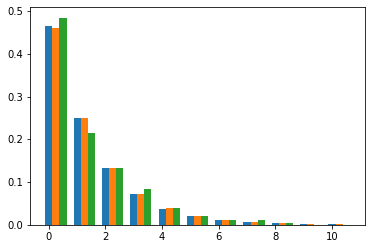

In [ ]:
#set up a test of the queueing network

np.random.seed(1009)#set a seed
num_nodes = 4

#Assign Service Rates
#mu = np.random.uniform(4.4,4.8, (num_nodes,1))
mu = np.random.uniform(1.6,1.8, (num_nodes,1))


alpha = np.random.uniform(0,.2,(num_nodes,1))

p_mat_o = np.random.uniform(0,1, (num_nodes,num_nodes+1))
p_mat_o = (p_mat_o.T/np.sum(p_mat_o, 1)).T #set the p's to sum to one.

p_mat = p_mat_o[:,:num_nodes]

print('routing matrix for this test: ')
print(p_mat)
print('')

print('exterior arrival rates')
print(alpha)
print('')

print('service rates')
print(mu)
print('')


Q = np.linalg.inv(np.identity(num_nodes) - p_mat.T)

lam = Q.dot(alpha)

num_dist = 10 #how many we calculate system distribution too



buffer_sizes = np.ones(num_nodes).astype(int)*100
test_sim = queue_sim(num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes)
test_sim.run_sim(100000)
dists, avg, trunc_avg = test_sim.get_queue_stats(num_dist)
j_dists, j_avgs = test_sim.get_jackson_stats(num_dist)

buffer_sizes = np.ones(num_nodes).astype(int)*8
buffer_sizes = [50,4,50,50]
buff_sim = queue_sim(num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes, BAS = True)
buff_sim.run_sim(1000)
h_dists, h_avg, h_trunc_avg = buff_sim.get_queue_stats(num_dist)

test = dists[0]
true = j_dists[0]
h_dist = h_dists[0]


plt.bar(np.arange(num_dist+1),true[0:num_dist+1], width = .25, label = 'jackson network dist')
plt.bar(np.arange(num_dist+1)+.25,test[0:num_dist+1], width = .25, label = 'queue_sim')
plt.bar(np.arange(num_dist+1)+.5,h_dist[0:num_dist+1], width = .25, label = 'blocking buffer queue_sim')
#plt.legend()

<BarContainer object of 11 artists>

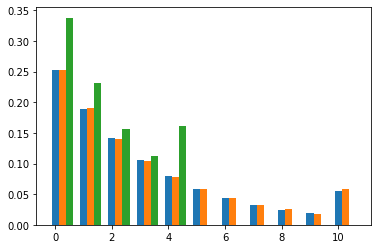

In [ ]:
test = dists[1]
true = j_dists[1]
h_dist = h_dists[1]

plt.bar(np.arange(num_dist+1),true[0:num_dist+1], width = .25, label = 'jackson network dist')
plt.bar(np.arange(num_dist+1)+.25,test[0:num_dist+1], width = .25, label = 'queue_sim')
plt.bar(np.arange(num_dist+1)+.5,h_dist[0:num_dist+1], width = .25, label = 'blocking buffer queue_sim')

<BarContainer object of 11 artists>

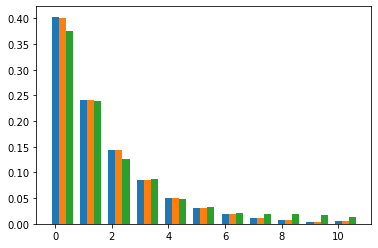

In [ ]:
test = dists[2]
true = j_dists[2]
h_dist = h_dists[2]

plt.bar(np.arange(num_dist+1),true[0:num_dist+1], width = .25, label = 'jackson network dist')
plt.bar(np.arange(num_dist+1)+.25,test[0:num_dist+1], width = .25, label = 'queue_sim')
plt.bar(np.arange(num_dist+1)+.5,h_dist[0:num_dist+1], width = .25, label = 'blocking buffer queue_sim')

1.0


<BarContainer object of 11 artists>

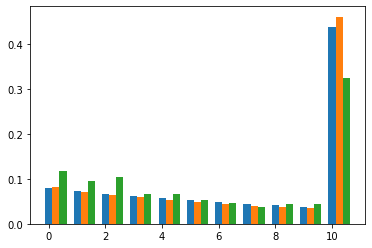

In [ ]:
test = dists[3]
true = j_dists[3]
h_dist = h_dists[3]

print(np.sum(test[0:num_dist+1]))

plt.bar(np.arange(num_dist+1),true[0:num_dist+1], width = .25, label = 'jackson network dist')
plt.bar(np.arange(num_dist+1)+.25,test[0:num_dist+1], width = .25, label = 'queue_sim')
plt.bar(np.arange(num_dist+1)+.5,h_dist[0:num_dist+1], width = .25, label = 'blocking buffer queue_sim')

###test network stats

<BarContainer object of 4 artists>

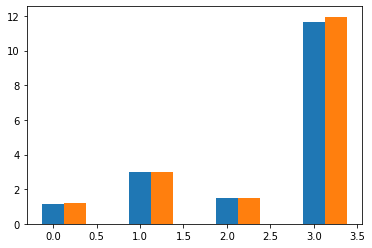

In [ ]:
plt.bar(np.arange(4), j_avgs,width = .25)
plt.bar(np.arange(4)+.25, avg,width=.25)
#print(j_avgs)

##Generating Random Queue Networks

###Routing Topologies

In [ ]:
def gen_buffers(num_nodes, p = .6):
  buffer_sizes = np.random.randint(1,10, num_nodes) #create random buffer sizes from 1 to 10
  large_buffers = np.random.binomial(1,p, num_nodes)
  buffer_sizes[large_buffers == 1] = 100# set 80% of the buffers to be large
  buffer_sizes = buffer_sizes.reshape(num_nodes, 1)

  return buffer_sizes


def build_sequential_route(num_nodes, width = None):
  if width is None:
    width = np.random.randint(2,5)

    if width >= num_nodes-1:
      width = 2

  p_mat_o = np.zeros((num_nodes, num_nodes+1))

  alpha = np.random.uniform(0,1.6,(num_nodes,1))
  alpha[width:,0] = 0

  num_rows = int(num_nodes/width)
  for queue_row in range(num_rows+1):
      start_row = queue_row*width
      end_row = min(queue_row*width+width, num_nodes)

      start_col = min((queue_row+1)*width, num_nodes)
      end_col = min((queue_row+1)*width + width, num_nodes+1)

      for row in range(start_row, end_row):
          p_mat_o[row,start_col:end_col] = np.ones(end_col-start_col)


  mu = np.random.uniform(.4,2, (num_nodes,1))

  p_mat_o = (p_mat_o.T/np.sum(p_mat_o, 1)).T

  buffer_sizes = gen_buffers(num_nodes, .4)
  return p_mat_o, alpha, mu, buffer_sizes


def build_variable_squential_route(num_nodes):
  p_mat_o = np.zeros((num_nodes, num_nodes+1))

  next_width = np.random.randint(1,5)
  if next_width >= num_nodes-1:
    next_width = 2

  alpha = np.random.uniform(0,1.6,(num_nodes,1))
  alpha[next_width:,0] = 0

  current_row = 0
  while current_row < num_nodes:
    width = next_width
    next_width = np.random.randint(1,5)

    start_row = current_row
    end_row = min(current_row+width,num_nodes)

    start_col = min(current_row+width, num_nodes)
    end_col = min(current_row+width + next_width, num_nodes+1)
    for row in range(start_row, end_row):

        p_mat_o[row,start_col:end_col] = np.ones(end_col-start_col)

    current_row = current_row+width

  if (np.any(np.sum(p_mat_o, 1) == 0)):
    print('error var sequential route')
    print(p_mat_o)

  mu = np.random.uniform(.5,1.5, (num_nodes,1))

  p_mat_o = (p_mat_o.T/np.sum(p_mat_o, 1)).T
  buffer_sizes = gen_buffers(num_nodes, .4)
  return p_mat_o, alpha, mu, buffer_sizes


def build_star_route(num_nodes):
  p_mat_o = np.zeros((num_nodes, num_nodes+1))
  p_mat_o[0,1:num_nodes] = 1
  p_mat_o[1:,-1] = 1

  alpha = np.zeros((num_nodes,1))
  alpha[0,0] = np.random.uniform(0,1*num_nodes)

  if (np.any(np.sum(p_mat_o, 1) == 0)):
    print('error star route')
    print(p_mat_o)

  p_mat_o = (p_mat_o.T/np.sum(p_mat_o, 1)).T

  mu = np.random.uniform(.3,1.4, (num_nodes,1))
  mu[0, 0] = np.random.uniform(.8*num_nodes, 1.2*num_nodes)

  buffer_sizes = gen_buffers(num_nodes, .8)
  return p_mat_o, alpha, mu, buffer_sizes

def build_random_route(num_nodes):
  p_mat_o = np.random.dirichlet(np.ones(num_nodes+1)*.1, num_nodes)

  alpha = np.random.uniform(0,.2,(num_nodes,1))

  if (np.any(np.sum(p_mat_o, 1) == 0)):
    print('error build_random_route')
    print(p_mat_o)

  mu = np.random.uniform(3*num_nodes/10,5*num_nodes/10, (num_nodes,1))
  p_mat_o = (p_mat_o.T/np.sum(p_mat_o, 1)).T

  buffer_sizes = gen_buffers(num_nodes, .85)

  return p_mat_o, alpha, mu, buffer_sizes

#build routing matrix
def gen_routing_mat(num_nodes, top = None):

  if top is None:
    top = np.random.randint(1,5)

  if top == 1:
    p_mat_o, alpha,mu, buffer_sizes = build_sequential_route(num_nodes)
  elif top ==2:
    p_mat_o, alpha,mu, buffer_sizes = build_variable_squential_route(num_nodes)
  elif top ==3:
    p_mat_o, alpha,mu, buffer_sizes = build_star_route(num_nodes)
  else:
    p_mat_o, alpha,mu, buffer_sizes = build_random_route(num_nodes)


  return p_mat_o, alpha,mu, top, buffer_sizes




###Generating the queue parameters

In [ ]:
#build queueing Parameters:

def gen_queue_params(num_nodes, top = None):


  p_mat_o, alpha, mu, graph_type, buffer_sizes = gen_routing_mat(num_nodes, top = top)

  p_mat = p_mat_o[:,:num_nodes]
  Q = np.linalg.inv(np.identity(num_nodes) - p_mat.T)
  lam = Q.dot(alpha)
  num_dist = 10

  forward_mat = p_mat.dot(p_mat) +p_mat #calculate matrices two steps forward in transition, and add these as edges
  adj_mat = 1*(forward_mat>0)

  #get edges from adjacency matrix
  edges = np.argwhere(adj_mat == 1) # n*2 matrix with column vectors [start nodes, end nodes]

  #get edge probs from p_mat
  edge_probs = np.array([p_mat[edges[i,0],edges[i,1]] for i in range(edges.shape[0])])
  edge_probs.reshape((-1,1))

  return mu, lam, alpha, p_mat_o, buffer_sizes, edges, edge_probs, graph_type



###Convergence speed tests

####Testing How Quickly Steady State Converges for nodes in a network

In [ ]:
### need to test the convergence of a queue sim to itself and its jackson distribution

np.random.seed(73)

#simplify buffer sim code
def build_test_sim(num_nodes, top = 1):
  mu, lam, alpha, p_mat_o, buffer_sizes, edges, edge_probs, graph_type = gen_queue_params(num_nodes, top = top)
  buff_sim = queue_sim(num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes, BAS = True)
  return buff_sim

#lets go through and build topology 1 networks and test their convergence
net_list = [build_test_sim(16, 3) for i in range(1)]
[i.run_sim(25600) for i in net_list]
[i.run_convergence_steps(step_list = [100,200,400,800, 1600, 3200, 6400, 12800,25600]) for i in net_list]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


[None]

<BarContainer object of 11 artists>

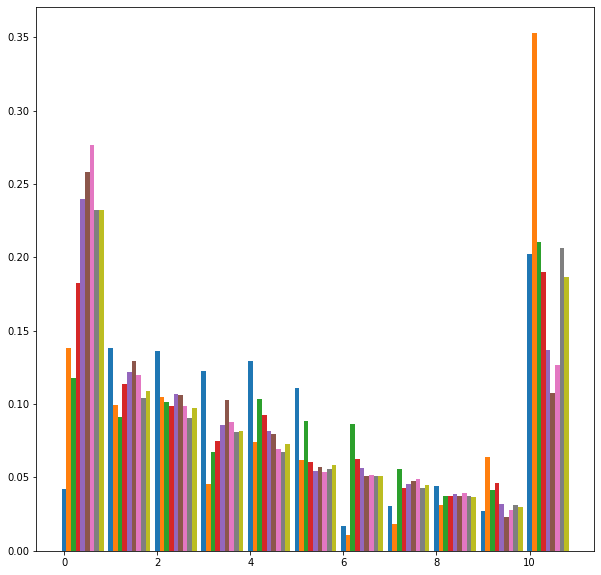

In [ ]:
i = net_list[0]
dist_test = i.node_list[15].dist_list
num_dist = dist_test.shape[1]
plt.rcParams['figure.figsize'] = [10, 10]
plt.bar(np.arange(num_dist),dist_test[0,:], width = .1, label = '100')
plt.bar(np.arange(num_dist)+.1,dist_test[1,:], width = .1, label = '200')
plt.bar(np.arange(num_dist)+.2,dist_test[2,:], width = .1, label = '400')
plt.bar(np.arange(num_dist)+.3,dist_test[3,:], width = .1, label = '800')
plt.bar(np.arange(num_dist)+.4,dist_test[4,:], width = .1, label = '1600')
plt.bar(np.arange(num_dist)+.5,dist_test[5,:], width = .1, label = '3200')
plt.bar(np.arange(num_dist)+.6,dist_test[6,:], width = .1, label = '6400')
plt.bar(np.arange(num_dist)+.7,dist_test[7,:], width = .1, label = '12800')
plt.bar(np.arange(num_dist)+.8,dist_test[8,:], width = .1, label = '25600')

####Testing how repeatable state distribution is for a network at t=800 seconds

4
set: 0
set: 1
set: 2
set: 3
set: 4
set: 5
set: 6
set: 7


<BarContainer object of 11 artists>

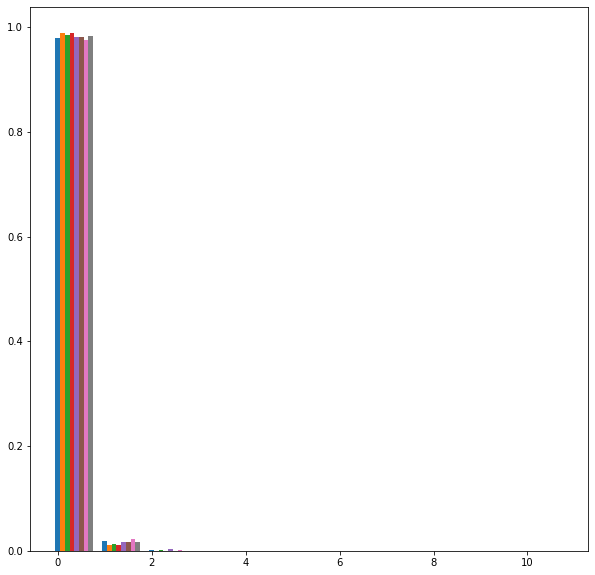

In [ ]:
np.random.seed(73)
num_nodes = 4
mu, lam, alpha, p_mat_o, buffer_sizes, edges, edge_probs, graph_type = gen_queue_params(num_nodes, top = 4)

print(len(mu))

dist_list = []
for i in range(8):
  print('set: ' + str(i))
  buff_sim = queue_sim(num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes, BAS = True)
  buff_sim.run_sim(800)
  dist_list.append(buff_sim.get_queue_stats(10)[0][2])



plt.bar(np.arange(num_dist),dist_list[0], width = .1, label = '1')
plt.bar(np.arange(num_dist)+.1,dist_list[1], width = .1, label = '2')
plt.bar(np.arange(num_dist)+.2,dist_list[2], width = .1, label = '3')
plt.bar(np.arange(num_dist)+.3,dist_list[3], width = .1, label = '4')
plt.bar(np.arange(num_dist)+.4,dist_list[4], width = .1, label = '5')
plt.bar(np.arange(num_dist)+.5,dist_list[5], width = .1, label = '6')
plt.bar(np.arange(num_dist)+.6,dist_list[6], width = .1, label = '7')
plt.bar(np.arange(num_dist)+.7,dist_list[7], width = .1, label = '8')


###Build DGL graph from run simulation

In [ ]:
#Build graph out of queueing network parameters and
#num_nodes - number of nodes in the queueing network
#num_events - number of events in the queueing sim
#num_dist - max queue length distribution
def build_qgraph(num_nodes, num_events = 1600, num_dist = 10, top = None, make_stats = False, seed = None, rerun = None):

  if seed is not None:
    np.random.seed(seed)
    mu, lam, alpha, p_mat_o, buffer_sizes, edges, edge_probs, graph_type = gen_queue_params(num_nodes, top = top)
    np.random.seed(None)

  else:
    mu, lam, alpha, p_mat_o, buffer_sizes, edges, edge_probs, graph_type = gen_queue_params(num_nodes, top = top)

  if rerun is None:
    #Run the simulation to get state distribution
    buff_sim = queue_sim(num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes, BAS = True)
    buff_sim.run_sim(num_events, verbose = False)
    state_dist, avg, trunc_avg = buff_sim.get_queue_stats(num_dist)
    jackson_dists, j_avgs = buff_sim.get_jackson_stats(num_dist)

    state_dist = np.stack(state_dist)
  else: #case where we rerun the simulation rerun times
    state_dists = []
    avgs = []
    trunc_avgs = []
    for i in range(rerun):
        buff_sim = queue_sim(num_nodes, mu, lam, alpha, p_mat_o, buffer_sizes, BAS = True)
        buff_sim.run_sim(num_events, verbose = False)
        state_dist, avg, trunc_avg = buff_sim.get_queue_stats(num_dist)
        state_dist = np.stack(state_dist)
        state_dists.append(state_dist)
        avgs.append(avg)
        trunc_avgs.append(trunc_avg)
    state_dist = np.mean(np.stack(state_dists), axis = 0)
    avg =  np.mean(np.stack(avgs), axis = 0)
    trunc_avg =  np.mean(np.stack(trunc_avgs), axis = 0)

  g = dgl.graph((edges[:,0], edges[:,1]), device=device)



  g.ndata['features'] = torch.from_numpy(np.concatenate([alpha,mu, buffer_sizes], axis = 1)).to(device).view(-1,3).float() #make sure to set the correct number of dimensions
  g.ndata['state_dist'] = torch.from_numpy(state_dist).to(device).float()
  g.edata['p_mat'] = torch.from_numpy(edge_probs).to(device).view(-1,1).float()

  if make_stats:
    jackson_dists, j_avgs = buff_sim.get_jackson_stats(num_dist)
    traffic_intensity = lam/mu

    g.ndata['avg'] = torch.from_numpy(avg).to(device).view(-1,1).float()
    g.ndata['t_avg'] = torch.from_numpy(trunc_avg).to(device).view(-1,1).float()
    g.ndata['alpha'] = torch.from_numpy(alpha).to(device).view(-1,1).float()
    g.ndata['buffer'] = torch.from_numpy(buffer_sizes).to(device).view(-1,1).float()
    g.ndata['mu'] = torch.from_numpy(mu).to(device).view(-1,1).float()
    g.ndata['lam'] = torch.from_numpy(lam).to(device).view(-1,1).float()
    g.ndata['traffic_intensity'] =torch.from_numpy(traffic_intensity).to(device).view(-1,1).float()
    g.ndata['jackson_dists'] =torch.from_numpy(traffic_intensity).to(device).view(-1,1).float()
    g.ndata['j_avg'] =torch.from_numpy(j_avgs).to(device).view(-1,1).float()

  return g

#function to handle seperating tuple if build_qgraph is being run from a multithreaded process
def M_build_qgraph(info_tuple):
  return build_qgraph(info_tuple[0],info_tuple[1])

##Testing properties of networks

###Topology 1

In [ ]:
graph_list_1 = [build_qgraph(np.random.randint(3, 20), num_events = 800, num_dist = 10, top =1) for i in range(200)]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


2.26909011388026
2.7540748954494565


(array([0.5036707 , 0.1663412 , 0.08126745, 0.0527805 , 0.04381886,
        0.02469877, 0.02311945, 0.02113631, 0.02313951, 0.06002725]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

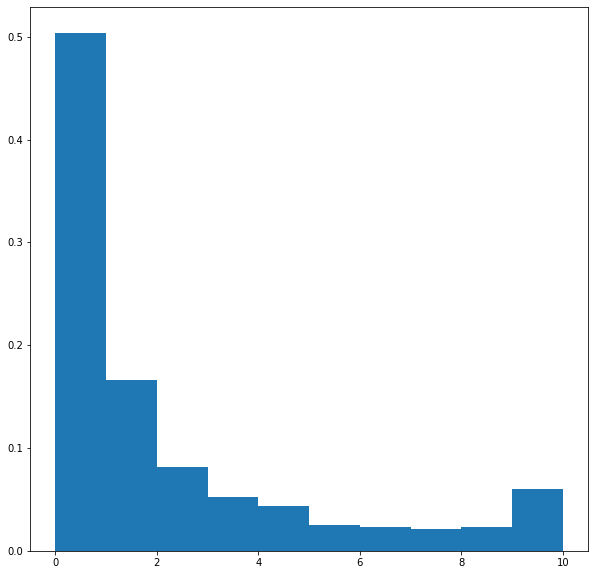

In [ ]:
state_dists = [i.ndata['state_dist'].cpu().numpy() for i in graph_list_1]
num_nodes = [[i.number_of_nodes()]*i.number_of_nodes() for i in graph_list_1]
num_nodes = np.array([item for sublist in num_nodes for item in sublist])

weights = (1/num_nodes)/np.sum(num_nodes)

state_dists = np.concatenate(state_dists)

avg_queue_len = np.sum(np.arange(11) * state_dists, axis = 1)

weighted_avg = np.average(avg_queue_len, weights = weights)
weighted_std = np.sqrt(np.cov(avg_queue_len, aweights=weights))

print(weighted_avg)
print(weighted_std)

plt.hist(avg_queue_len, np.arange(11), weights = weights, density = True)


###Topology 2

In [ ]:
graph_list_2 = [build_qgraph(np.random.randint(3, 20), num_events = 800, num_dist = 10, top =2) for i in range(200)]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


2.2504299708630398
2.8816808757077577


(array([0.53050073, 0.1380147 , 0.07450206, 0.05388847, 0.04497439,
        0.02543908, 0.03055776, 0.01344853, 0.01420717, 0.07446711]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

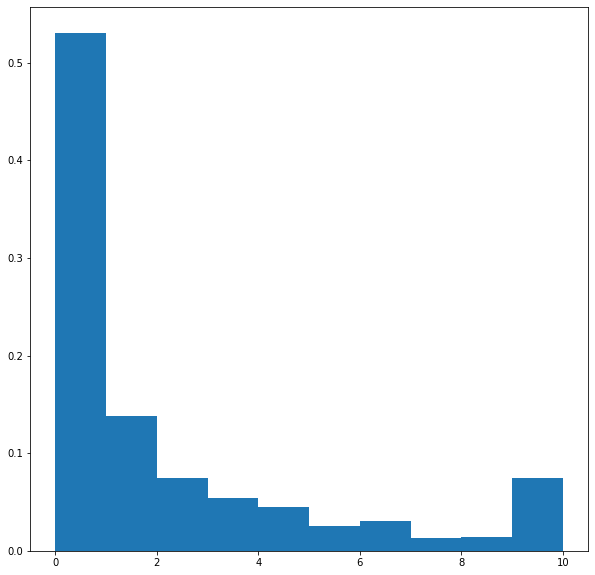

In [ ]:
state_dists = [i.ndata['state_dist'].cpu().numpy() for i in graph_list_2]
num_nodes = [[i.number_of_nodes()]*i.number_of_nodes() for i in graph_list_2]
num_nodes = np.array([item for sublist in num_nodes for item in sublist])

weights = (1/num_nodes)/np.sum(num_nodes)

state_dists = np.concatenate(state_dists)

avg_queue_len = np.sum(np.arange(11) * state_dists, axis = 1)

weighted_avg = np.average(avg_queue_len, weights = weights)
weighted_std = np.sqrt(np.cov(avg_queue_len, aweights=weights))

print(weighted_avg)
print(weighted_std)

plt.hist(avg_queue_len, np.arange(11), weights = weights, density = True)

###Topology 3

In [ ]:
graph_list_3 = [build_qgraph(np.random.randint(3, 20), num_events = 800, num_dist = 10, top =3) for i in range(200)]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


2.217841544097317
2.777010172934278


(array([0.52700165, 0.16843644, 0.06337592, 0.04806197, 0.02922071,
        0.02922852, 0.02740335, 0.02758296, 0.0206099 , 0.05907856]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

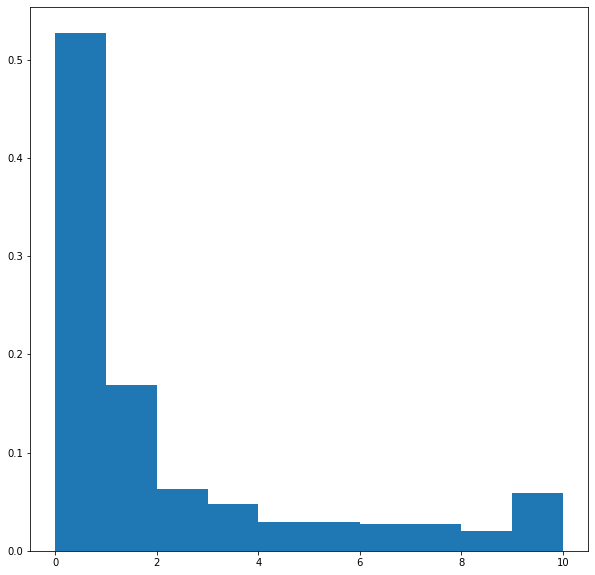

In [ ]:
state_dists = [i.ndata['state_dist'].cpu().numpy() for i in graph_list_3]
num_nodes = [[i.number_of_nodes()]*i.number_of_nodes() for i in graph_list_3]
num_nodes = np.array([item for sublist in num_nodes for item in sublist])

weights = (1/num_nodes)/np.sum(num_nodes)

state_dists = np.concatenate(state_dists)

avg_queue_len = np.sum(np.arange(11) * state_dists, axis = 1)

weighted_avg = np.average(avg_queue_len, weights = weights)
weighted_std = np.sqrt(np.cov(avg_queue_len, aweights=weights))

print(weighted_avg)
print(weighted_std)

plt.hist(avg_queue_len, np.arange(11), weights = weights, density = True)

###Topology 4

In [ ]:
graph_list_4 = [build_qgraph(np.random.randint(3, 20), num_events = 800, num_dist = 10, top =4) for i in range(200)]



2.3950027118117743
3.1884696159831374


(array([0.59458692, 0.06071528, 0.0449446 , 0.03899685, 0.03022861,
        0.03904444, 0.04009448, 0.04497513, 0.04143894, 0.06497474]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

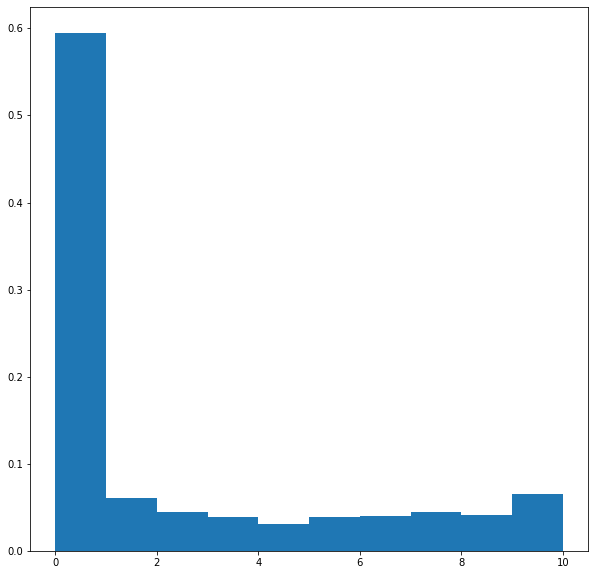

In [ ]:
state_dists = [i.ndata['state_dist'].cpu().numpy() for i in graph_list_4]
num_nodes = [[i.number_of_nodes()]*i.number_of_nodes() for i in graph_list_4]
num_nodes = np.array([item for sublist in num_nodes for item in sublist])

weights = (1/num_nodes)/np.sum(num_nodes)

state_dists = np.concatenate(state_dists)

avg_queue_len = np.sum(np.arange(11) * state_dists, axis = 1)

weighted_avg = np.average(avg_queue_len, weights = weights)
weighted_std = np.sqrt(np.cov(avg_queue_len, aweights=weights))

print(weighted_avg)
print(weighted_std)

plt.hist(avg_queue_len, np.arange(11), weights = weights, density = True)

###Dataset Class for Queues

In [ ]:
from dgl.data import DGLDataset

class queue_graph_dataset(DGLDataset):
  def __init__(self, num_graphs, min_nodes, max_nodes, num_events = 1600, top = None, rerun = None):

    self.num_graphs = num_graphs
    self.min_nodes = min_nodes
    self.max_nodes = max_nodes
    self.num_events = num_events
    self.num_dist = 10 #the number of items in queue we will calculate probability out too
    self.top = top
    self.rerun = rerun

    super(queue_graph_dataset, self).__init__(name="queue_dataset", hash_key=(num_graphs,  min_nodes, max_nodes))

  def process(self):
    self.graphs = []
    for i in range(self.num_graphs):
      print(i)
      self.graphs.append(build_qgraph(np.random.randint(self.min_nodes, self.max_nodes), self.num_events, self.num_dist, self.top, rerun = self.rerun))
    #self.graphs = [build_qgraph(np.random.randint(self.min_nodes, self.max_nodes), self.num_events, self.num_dist, self.top) for i in range(self.num_graphs)]
    self.labels = [self.graphs[i].ndata['state_dist'] for i in range(self.num_graphs)]



  def __getitem__(self, i):
    return self.graphs[i], self.labels[i]

  def __len__(self):
    return len(self.graphs)


In [ ]:
set_default(figsize=(3,3), dpi= 150)
def draw(g, title):
  plt.figure()
  #kamada_kawai_layout
  pos=nx.nx_pydot.graphviz_layout(g.to_networkx())
  nx.draw(g.to_networkx(), pos,  with_labels=True, node_color='skyblue', edge_color='red', width = g.edata['p_mat']*3)
  plt.gcf().set_facecolor('w')
  plt.title(title)

####Visualize a set of generated queues

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


1
2
3
4
5
6
7
8
9


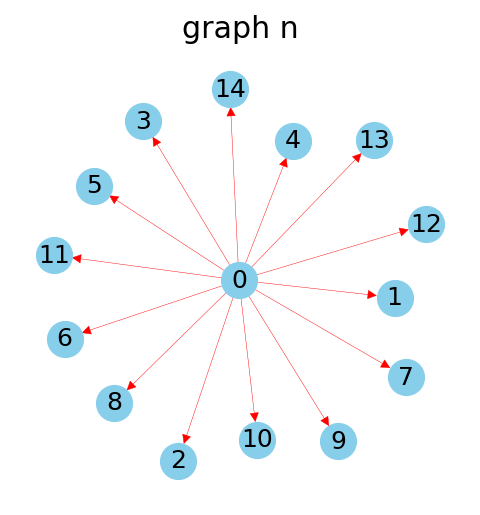

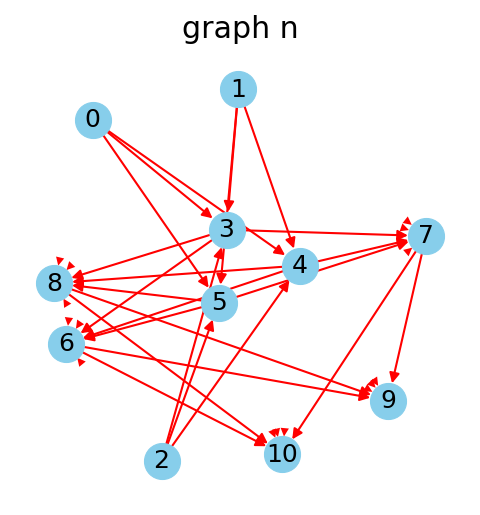

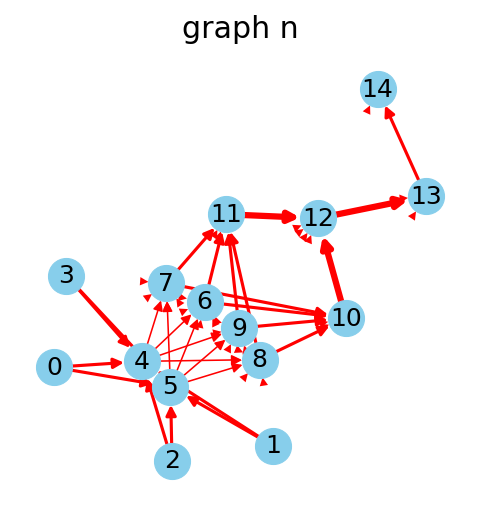

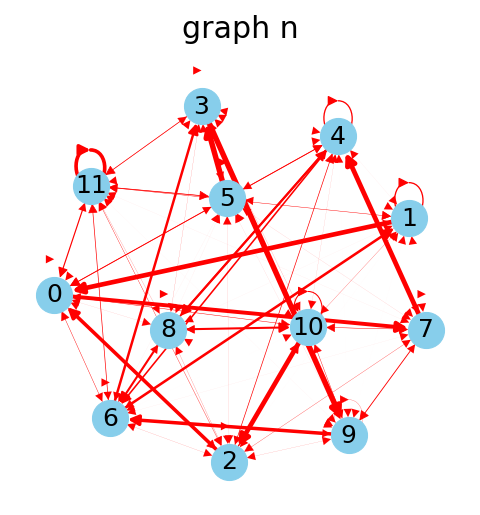

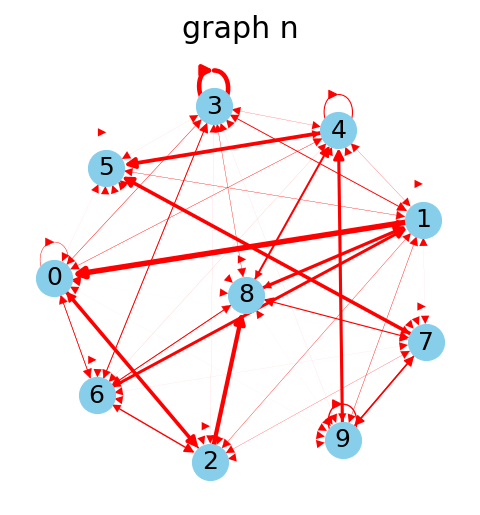

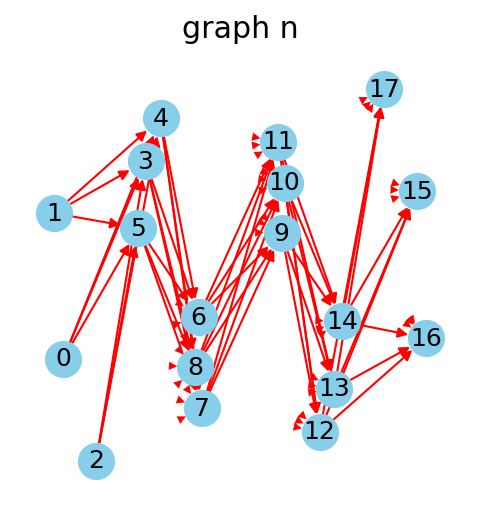

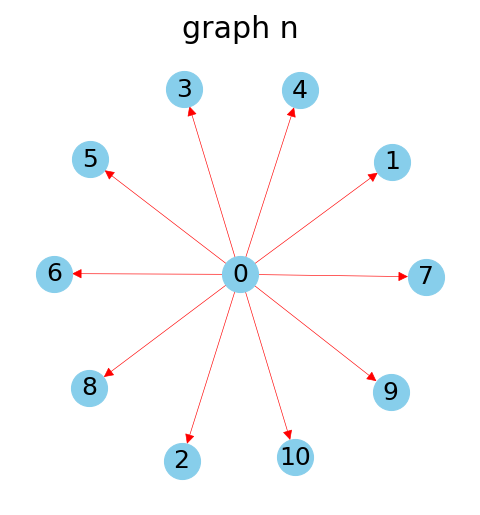

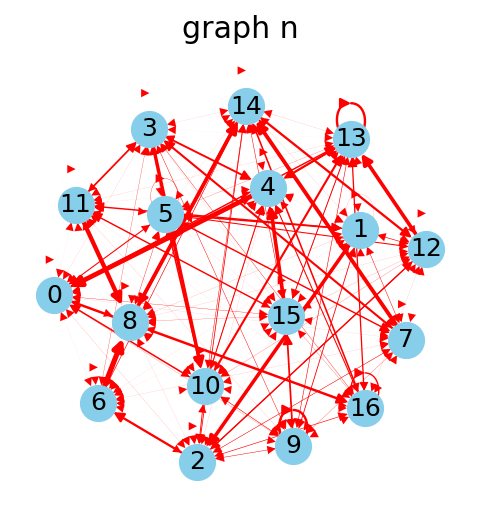

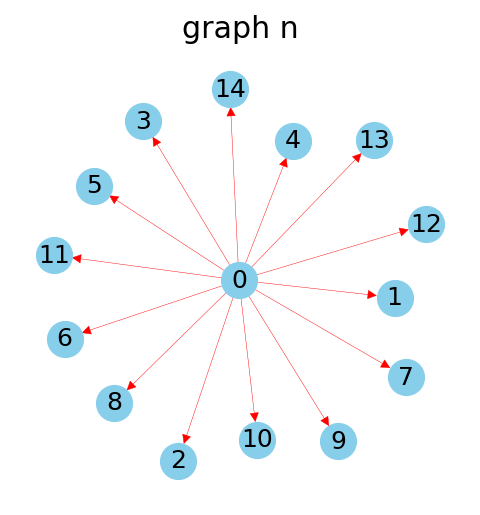

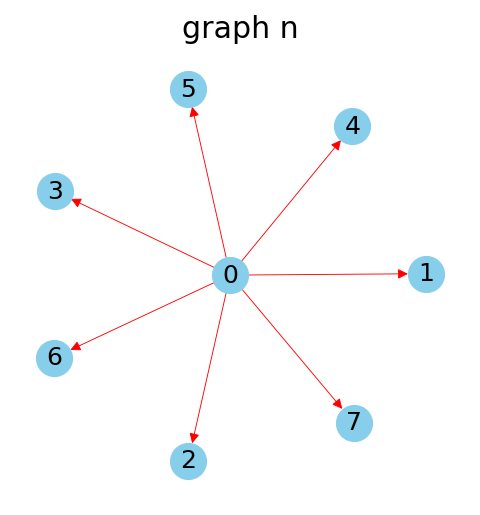

In [ ]:
# visualise the 8 classes of graphs
for graph, label in queue_graph_dataset(10, 6, 20, 800):
    draw(graph.cpu(), 'graph n')

#Generate Training and Testing Datasets

In [ ]:
# Generate artifical graph dataset
import time
t1 = time.time()

train_size = 16000
test_size = 400

trainset = queue_graph_dataset(train_size, 3,20, 800) #create trainsize graphs between 3 and 20 nodes, simulated for 800 seconds
testset = queue_graph_dataset(test_size,3,20, 800)
print( str(train_size + test_size) + ' queueing sims run in ' + str(time.time()-t1))

print(trainset[0][1])

#test_g = trainset[0][0]
#print(test_g.ndata['lam'])
#print(test_g.ndata['alpha'])
#print(test_g.ndata['traffic_intensity'])


0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


Streaming output truncated to the last 5000 lines.
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
1

##Neural Network Layer Classes

\begin{aligned}
\boldsymbol{h} &=\boldsymbol{x}+\left(A \boldsymbol{x}+\sum_{v_{j} \rightarrow v} \eta\left(e_{j}\right) \odot B \boldsymbol{x}_{j}\right)^{+} \\
\eta\left(e_{j}\right) &=\sigma\left(e_{j}\right)\left(\sum_{v_{k} \rightarrow v} \sigma\left(e_{k}\right)\right)^{-1} \\
e_{j} &=C e_{j}^{\boldsymbol{x}}+D \boldsymbol{x}_{j}+E \boldsymbol{x}, \quad e_{j}^{h}=e_{j}^{\boldsymbol{x}}+\left(e_{j}\right)^{+}
\end{aligned}

GatedGCNs equations



In DGL, the message functions are expressed as Edge UDFs (User Defined Functions). Edge UDFs take in a single argument edges. It has three members **src, dst, and data** for accessing source node features, destination node features, and edge features.

The reduce functions are Node UDFs. Node UDFs have a single argument nodes, which has two members **data** and **mailbox**. data contains the node features and mailbox contains all incoming message features, stacked along the **second dimension** (hence the dim=1 argument).

update_all(message_func, reduce_func) send messages through all edges and update all nodes. Optionally, apply a function to update the node features after receive. This is a convenient combination for performing send(g.edges(), message_func) and recv(g.nodes(), reduce_func).

###GatedGCN Layer

In [ ]:
class GatedGCN_layer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.A = nn.Linear(input_dim, output_dim, device = device) #weight on node value(s)
    self.B = nn.Linear(input_dim, output_dim, device = device) #weight on adjacent node values
    self.C = nn.Linear(input_dim, output_dim, device = device) #weight on edge values for edge activation
    self.D = nn.Linear(input_dim, output_dim, device = device) #weight on incoming node values for edge activation
    self.E = nn.Linear(input_dim, output_dim, device = device) #weight on current node for edge activation
    self.bn_node_h = nn.BatchNorm1d(output_dim, device = device) #batch normalization for the hidden representation
    self.bn_node_e = nn.BatchNorm1d(output_dim, device = device) #batch normalization for the edges

  def message_func(self, edges):
    Bx_j = edges.src['BX'] #source node features
    #e_j = Ce_j + Dxj + Ex
    e_j = edges.data['CE'] + edges.src['DX'] + edges.dst['EX']
    edges.data['E'] = e_j
    return {'Bx_j' : Bx_j, 'e_j' : e_j}

  #opens mailbox and check what information has arrived at this node
  def reduce_func(self, nodes):
    Ax = nodes.data['AX']
    Bx_j = nodes.mailbox['Bx_j'] #gets messages recieved (representation that lives on bj)
    e_j = nodes.mailbox['e_j']
    # sigma_j = σ(e_j)
    σ_j = torch.sigmoid(e_j)
    # h = Ax + Σ_j η_j * Bxj
    h = Ax + torch.sum(σ_j * Bx_j, dim=1) / (torch.sum(σ_j, dim=1) + .000001)
    return {'H' : h}

  #define function for the forward pass
  #g graph
  #X "collection of all these vertices"
  #E_X - set of edges
  def forward(self, g, X, E_X, snorm_n, snorm_e):

        g.ndata['H']  = X
        g.ndata['AX'] = self.A(X)
        g.ndata['BX'] = self.B(X)
        g.ndata['DX'] = self.D(X)
        g.ndata['EX'] = self.E(X)
        g.edata['E']  = E_X
        g.edata['CE'] = self.C(E_X) #C is multiplying the edge

        g.update_all(self.message_func, self.reduce_func)

        H = g.ndata['H'] # result of graph convolution
        E = g.edata['E'] # result of graph convolution

        #UNCOMMENT TO ADD NODE/EDGE NORMALIZATION
        '''
        H *= snorm_n # normalize activation w.r.t. graph node size
        E *= snorm_e # normalize activation w.r.t. graph edge size
        '''

        H = self.bn_node_h(H) # batch normalization
        E = self.bn_node_e(E) # batch normalization

        H = torch.relu(H) # non-linear activation
        E = torch.relu(E) # non-linear activation

        H = X + H # residual connection
        E = E_X + E # residual connection

        return H, E


### Fully Connected Layer

In [ ]:
#final layer to aggregate hidden layers for each node
class MLP_layer(nn.Module):

    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super().__init__()
        list_FC_layers = [
            nn.Linear(input_dim, input_dim, device = 'cuda:0') for l in range(L)
        ]
        list_FC_layers.append(nn.Linear(input_dim, output_dim, device = 'cuda:0'))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L

    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return   y

###Gated GCN Neural Network

In [ ]:
class GatedGCN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, L):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim, device = 'cuda:0')
        self.embedding_e = nn.Linear(1, hidden_dim, device = 'cuda:0')
        self.GatedGCN_layers = nn.ModuleList([
            GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L)
        ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)

    #self, batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e
    def forward(self, g, X, E, snorm_n, snorm_e):

        # input embedding
        H = self.embedding_h(X)
        E = self.embedding_e(E)

        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            H, E = GGCN_layer(g, H, E, snorm_n, snorm_e)

        #convert from node space to network space
        # MLP classifier
        g.ndata['H'] = H
        #y = dgl.mean_nodes(g, 'H')
        y = self.MLP_layer(H)
        return y


##Define Graph Network Fuctions

###Colate Function

In [ ]:
# Collate function to prepare graphs (used with batch function, which itself is used for fast information retrieval in training process)

#returns graph, labels, nomalized node features, normalized edge features
def collate(samples):
    graphs, labels = map(list, zip(*samples))  # samples is a list of pairs (graph, label)

    labels = torch.cat(labels).cuda(0)#concatenate the labels
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).cuda(0).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).cuda(0).sqrt()  # graph size normalization
    sizes_e = [graph.number_of_edges() for graph in graphs] # number of edges
    snorm_e = [torch.FloatTensor(size, 1).cuda(0).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).cuda(0).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph, labels, snorm_n, snorm_e

###prep_graph() funcition

In [ ]:
#function to collate graph without batching
def prep_graph(q_graph):
  labels = q_graph.ndata['state_dist']
  size_n = q_graph.number_of_nodes()# graph size
  snorm_n = torch.FloatTensor(size_n, 1).cuda(0).fill_(1 / size_n)
  snorm_n = snorm_n.sqrt()  # graph size normalization
  sizes_e = q_graph.number_of_edges()# number of edges
  snorm_e = torch.FloatTensor(sizes_e, 1).cuda(0).fill_(1 / sizes_e)
  snorm_e = snorm_e.sqrt()  # graph size normalization
  return q_graph, labels, snorm_n, snorm_e

### Define Accuracy

In [ ]:
# Compute accuracy
def accuracy(logits, targets):
    preds = logits.detach()
    acc = ((preds-targets)**2).sum().item()
    return acc

### Train one epoch

In [ ]:
def train(model, data_loader, loss):

    model.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0

    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_X = batch_graphs.ndata['features']
        batch_E = batch_graphs.edata['p_mat']

        batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)
        J = loss(batch_scores, batch_labels)
        optimizer.zero_grad()
        J.backward()
        optimizer.step()

        epoch_loss += J.detach().item()
        epoch_train_acc += accuracy(batch_scores, batch_labels)
        nb_data += batch_labels.size(0)

    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data

    return epoch_loss, epoch_train_acc

### Evaluation

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
def evaluate(model, data_loader, loss):

    model.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0

    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):

            batch_graphs = batch_graphs.to(device)
            batch_labels = batch_labels.to(device)

            batch_X = batch_graphs.ndata['features'].cuda(0)
            batch_E = batch_graphs.edata['p_mat'].cuda(0)

            batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)
            J = loss(batch_scores, batch_labels)

            epoch_test_loss += J.detach().item()
            epoch_test_acc += accuracy(batch_scores, batch_labels)
            nb_data += batch_labels.size(0)

        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data

    return epoch_test_loss, epoch_test_acc

## Test Network Functions

In [ ]:
# instantiate network
model = GatedGCN(input_dim=3, hidden_dim=15, output_dim=11, L=2)
print(model)

GatedGCN(
  (embedding_h): Linear(in_features=3, out_features=15, bias=True)
  (embedding_e): Linear(in_features=1, out_features=15, bias=True)
  (GatedGCN_layers): ModuleList(
    (0): GatedGCN_layer(
      (A): Linear(in_features=15, out_features=15, bias=True)
      (B): Linear(in_features=15, out_features=15, bias=True)
      (C): Linear(in_features=15, out_features=15, bias=True)
      (D): Linear(in_features=15, out_features=15, bias=True)
      (E): Linear(in_features=15, out_features=15, bias=True)
      (bn_node_h): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedGCN_layer(
      (A): Linear(in_features=15, out_features=15, bias=True)
      (B): Linear(in_features=15, out_features=15, bias=True)
      (C): Linear(in_features=15, out_features=15, bias=True)
      (D): Linear(in_features=15, out_features=15, bias=True)
      (E): 

In [ ]:

# Define DataLoader and get first graph batch

train_loader = DataLoader(trainset, batch_size=1, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))
#batch_graphs, batch_labels = next(iter(train_loader))
batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

###Check variable sizes

In [ ]:
# Checking some sizes

print(f'batch_graphs:', batch_graphs)
print(f'batch_labels:', batch_labels)
print('labels size:', batch_labels.size())
print('batch_X size:', batch_X.size())
print('batch_E size:', batch_E.size())

batch_graphs: Graph(num_nodes=16, num_edges=256,
      ndata_schemes={'features': Scheme(shape=(3,), dtype=torch.float32), 'state_dist': Scheme(shape=(11,), dtype=torch.float32)}
      edata_schemes={'p_mat': Scheme(shape=(1,), dtype=torch.float32)})
batch_labels: tensor([[ 9.1089e-01,  7.6321e-02,  1.0598e-02,  1.8453e-03,  2.8338e-04,
          6.0978e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.2204e-16],
        [ 3.2584e-01,  4.2505e-02,  1.8029e-02,  2.4946e-02,  1.6032e-02,
          2.9449e-02,  3.2402e-02,  5.1080e-01,  0.0000e+00,  0.0000e+00,
          1.1102e-16],
        [ 2.0426e-01,  9.4312e-02,  4.4829e-02,  1.8416e-02,  9.5508e-03,
          5.4691e-03,  1.6516e-03,  4.6393e-04,  3.3031e-04,  7.6770e-04,
          6.1995e-01],
        [ 4.2455e-02,  3.9036e-02,  3.1399e-02,  3.1748e-02,  2.8569e-02,
          3.0088e-02,  2.1728e-02,  1.1934e-02,  9.8350e-03,  5.4269e-03,
          7.4778e-01],
        [ 5.8370e-01,  8.6188e-02,  1.4366e-02,  4.

###Quick Accuracy Test

In [ ]:
batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())
print(batch_scores[0,:])
print(batch_labels.size())
print(f'accuracy: {accuracy(batch_scores, batch_labels)}')
#print(torch.cat([batch_scores,batch_labels], axis = 1))

torch.Size([16, 11])
tensor([ 0.6240, -1.6638, -2.1126,  2.1720, -0.6323,  1.4755,  0.7588,  1.8443,
        -1.0108,  1.8098, -1.1025], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([16, 11])
accuracy: 285.81597900390625


Test Backward Pass

In [ ]:
# Loss
J = nn.MSELoss()(batch_scores, batch_labels)

# Backward pass
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.zero_grad()
J.backward()
optimizer.step()

# Train GNN Model

##model 1

In [ ]:
# datasets
train_loader = DataLoader(trainset, batch_size=200, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)

# Create model
#model = GatedGCN(input_dim=3, hidden_dim=60, output_dim=11, L=8)
#loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_train_losses = []
epoch_test_losses = []
epoch_train_accs = []
epoch_test_accs = []
start = time.time()
for epoch in range(2500):

    train_loss, train_acc = train(model, train_loader, loss)
    test_loss, test_acc = evaluate(model, test_loader, loss)

    epoch_train_losses.append(train_loss)
    epoch_test_losses.append(train_acc)
    epoch_train_accs.append(test_loss)
    epoch_test_accs.append(test_acc)

    print(f'Epoch {epoch}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}')

print(time.time() - start)

Epoch 0, train_loss: 0.0060, test_loss: 0.0076
train_acc: 0.0661, test_acc: 0.0839
Epoch 1, train_loss: 0.0056, test_loss: 0.0124
train_acc: 0.0615, test_acc: 0.1366
Epoch 2, train_loss: 0.0054, test_loss: 0.0070
train_acc: 0.0598, test_acc: 0.0764
Epoch 3, train_loss: 0.0055, test_loss: 0.0115
train_acc: 0.0610, test_acc: 0.1264
Epoch 4, train_loss: 0.0054, test_loss: 0.0112
train_acc: 0.0596, test_acc: 0.1231
Epoch 5, train_loss: 0.0055, test_loss: 0.0102
train_acc: 0.0601, test_acc: 0.1119
Epoch 6, train_loss: 0.0054, test_loss: 0.0140
train_acc: 0.0593, test_acc: 0.1542
Epoch 7, train_loss: 0.0053, test_loss: 0.0195
train_acc: 0.0583, test_acc: 0.2141
Epoch 8, train_loss: 0.0054, test_loss: 0.0158
train_acc: 0.0597, test_acc: 0.1740
Epoch 9, train_loss: 0.0053, test_loss: 0.0118
train_acc: 0.0582, test_acc: 0.1299
Epoch 10, train_loss: 0.0055, test_loss: 0.0107
train_acc: 0.0604, test_acc: 0.1177
Epoch 11, train_loss: 0.0052, test_loss: 0.0083
train_acc: 0.0574, test_acc: 0.0910
Ep



```
# This is formatted as code
```

##test prediction quality

In [ ]:
import pandas as pd

def get_mse_stats(q_graph, logit_preds):

  preds = logit_preds.detach().cpu().numpy()
  labels = q_graph.ndata['state_dist'].cpu().numpy()

  num_dist =preds.shape[1]

  nn_avg = np.sum(np.arange(num_dist)* preds, axis = 1)
  sim_avg = q_graph.ndata['t_avg'].cpu().numpy().reshape(-1,)

  #rss_prob = np.sum((preds-labels)**2)
  #mape_avg = np.mean(np.abs((nn_avg - sim_avg)/sim_avg))
  #r_2_util = 1 - np.sum((preds[0,:]-labels[0,:])**2)/np.sum((labels[0,:]-np.mean(labels[0,:]))**2)

  mse_avg = np.sqrt(np.mean((nn_avg - sim_avg)**2))
  mse_util = np.sqrt(np.mean((preds[0,:]-labels[0,:])**2))
  mse_prob = np.sqrt(np.mean((preds-labels)**2))


  return mse_prob, mse_util, mse_avg


def get_stats_scores(num_nodes, num_events=800, num_dist = 10, top = 1, seed = None, rerun = 5):
    q_graph = build_qgraph(num_nodes = num_nodes, num_events = num_events, num_dist = num_dist, top = top, make_stats = True, seed = seed, rerun = rerun)
    batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = prep_graph(q_graph)

    batch_X = batch_graphs.ndata['features']
    batch_E = batch_graphs.edata['p_mat']
    batch_features = batch_X.cpu().numpy()
    buffers = batch_X[:,2]
    batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

    #print(batch_scores.detach())

    rmse_prob, rmse_util, rmse_avg = get_mse_stats(q_graph, batch_scores)


    probs = q_graph.ndata['state_dist'].cpu().numpy()
    utils = probs[0,:]
    avgs = q_graph.ndata['t_avg'].cpu().numpy().reshape(-1,)

    return rmse_prob, rmse_util, rmse_avg, probs, utils, avgs

def test_top(top = 1, num_tests = 120, node_list = [3,7,10,20, 30, 40], rerun = 1):
    ##Test accuracy of point estimates
    print('starting topology: ' + str(top))
    print('')

    np.random.seed(38)
    num_dist = 10

    data_list = []

    for num_nodes in node_list:
      print('number of nodes: ' + str(num_nodes))
      res_list = [get_stats_scores(num_nodes, top = top, seed = i, rerun = rerun) for i in range(num_tests)]

      mse_prob = np.mean([i[0] for i in res_list])
      mse_util = np.mean([i[1] for i in res_list])
      mse_avg = np.mean([i[2] for i in res_list])

      std_prob = np.std(np.stack([i[3].reshape(-1,) for i in res_list]))
      std_util = np.std(np.stack([i[4].reshape(-1,) for i in res_list]))
      std_avg = np.std(np.stack([i[5].reshape(-1,) for i in res_list]))

      std_mprob = np.std([i[0] for i in res_list])
      std_mutil = np.std([i[1] for i in res_list])
      std_mavg = np.std([i[2] for i in res_list])


      data_list.append([mse_prob, mse_util, mse_avg, std_prob, std_util, std_avg, std_mprob, std_mutil, std_mavg])

    data_table = pd.DataFrame(data = data_list, columns = ['rmse_prob','rmse_util','rmse_avg','std_prob','std_util','std_avg','std_mprob','std_mutil','std_mavg'], index =node_list)

    return data_table

In [ ]:
data_table = test_top(1)
data_table

starting topology: 1

number of nodes: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


number of nodes: 7
number of nodes: 10
number of nodes: 20
number of nodes: 30
number of nodes: 40


,rmse_prob,rmse_util,rmse_avg,std_prob,std_util,std_avg,std_mprob,std_mutil,std_mavg
3,0.079845,0.077551,1.453847,0.184895,0.196166,3.242509,0.038235,0.061229,1.105481
7,0.073850,0.062685,1.381274,0.191188,0.202803,3.108815,0.026443,0.047692,0.679492
10,0.066534,0.056749,1.250924,0.186342,0.208238,2.906166,0.026296,0.043746,0.659966
20,0.062341,0.050085,1.168223,0.180164,0.196777,2.507485,0.023685,0.043764,0.507240
30,0.068995,0.050667,1.279593,0.180458,0.199977,2.343693,0.023266,0.039631,0.544342
40,0.066250,0.049945,1.182955,0.185056,0.206748,2.164298,0.021142,0.043178,0.483031


In [ ]:
data_table = test_top(2)
data_table

starting topology: 2

number of nodes: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


number of nodes: 7
number of nodes: 10
number of nodes: 20
number of nodes: 30
number of nodes: 40


,rmse_prob,rmse_util,rmse_avg,std_prob,std_util,std_avg,std_mprob,std_mutil,std_mavg
3,0.068197,0.069087,1.061917,0.193162,0.191095,3.298705,0.031336,0.047947,0.907214
7,0.073556,0.064074,1.225616,0.207679,0.214830,3.241682,0.032890,0.057611,0.777405
10,0.072755,0.065554,1.175508,0.203940,0.215514,2.947839,0.038775,0.056123,0.753345
20,0.075141,0.075535,1.141195,0.211868,0.213350,2.587833,0.040139,0.059221,0.683844
30,0.083635,0.086001,1.311505,0.212962,0.219759,2.472998,0.034124,0.067573,0.646341
40,0.081546,0.073949,1.255780,0.218521,0.222888,2.295248,0.033056,0.065500,0.628810


In [ ]:
data_table = test_top(3)
data_table

starting topology: 3

number of nodes: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


number of nodes: 7
number of nodes: 10
number of nodes: 20
number of nodes: 30
number of nodes: 40


,rmse_prob,rmse_util,rmse_avg,std_prob,std_util,std_avg,std_mprob,std_mutil,std_mavg
3,0.061912,0.065531,1.235107,0.205116,0.221802,3.189078,0.038463,0.057877,0.950411
7,0.044389,0.049706,0.813237,0.202674,0.223237,2.697786,0.027668,0.046841,0.651995
10,0.049002,0.057113,0.913958,0.199327,0.233113,2.569438,0.034008,0.064508,0.777159
20,0.043065,0.049365,0.795130,0.198769,0.241307,2.281191,0.021252,0.056169,0.521070
30,0.095533,0.089273,1.374428,0.198555,0.244980,1.988467,0.050714,0.086563,0.878514
40,0.137743,0.232243,2.217207,0.196869,0.247724,1.993379,0.069254,0.250192,1.716834


In [ ]:
data_table = test_top(4)
data_table

starting topology: 4

number of nodes: 3
number of nodes: 7
number of nodes: 10
number of nodes: 20
number of nodes: 30
number of nodes: 40


,rmse_prob,rmse_util,rmse_avg,std_prob,std_util,std_avg,std_mprob,std_mutil,std_mavg
3,0.068882,0.067877,1.435370,0.225128,0.221564,3.744989,0.055318,0.071765,1.442888
7,0.094498,0.072225,2.084018,0.221293,0.228811,3.237626,0.068280,0.083426,1.779469
10,0.095230,0.072080,2.000009,0.222014,0.224420,3.086467,0.074023,0.085552,1.900908
20,0.128885,0.116830,2.574879,0.218364,0.222579,3.085230,0.094324,0.113775,2.429507
30,0.146230,0.128628,2.369132,0.220821,0.223451,2.961302,0.097318,0.109678,2.641722
40,0.183201,0.170838,2.636994,0.214363,0.218137,3.066326,0.089360,0.109963,2.643973


##Test model 1 network on Example Graph

###graph example 1

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([  9., 100.,   8.,   2.,   9.,   8.,   5., 100.,   9.,   7.],
       device='cuda:0')


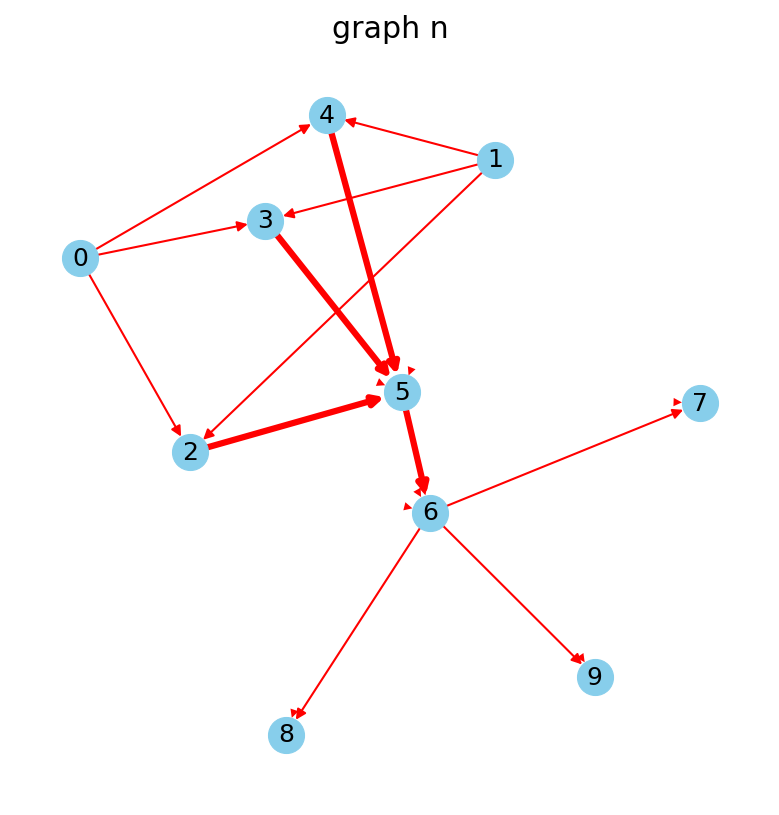

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
np.random.seed(30)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800, rerun = 1)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)


<BarContainer object of 11 artists>

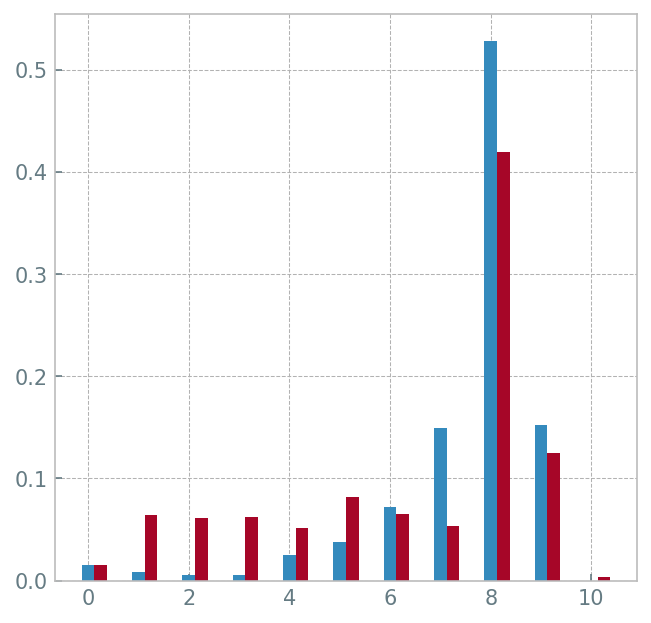

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.0029958
1.0


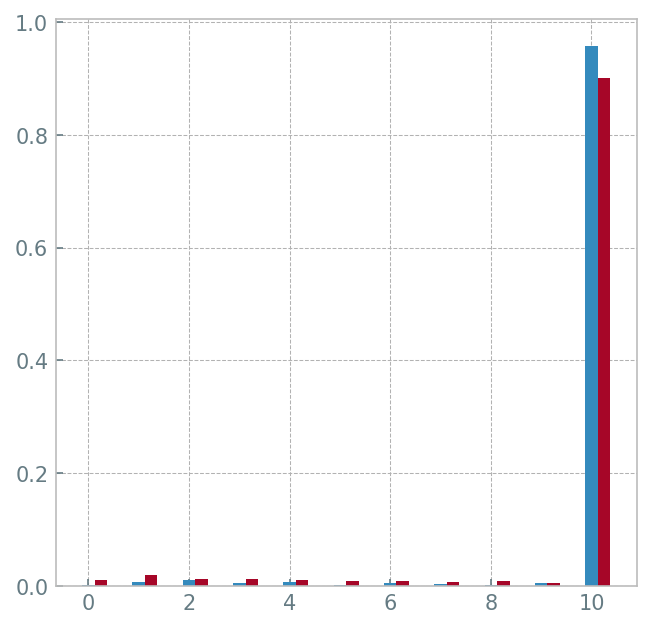

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
print(np.sum(batch_scores[1,:]))
print(np.sum(batch_labels[1,:]))

<BarContainer object of 11 artists>

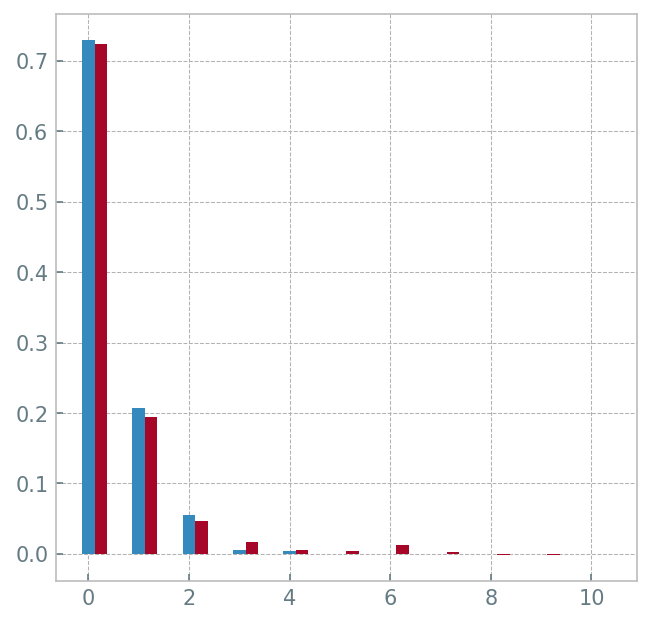

In [ ]:
#node 2
node = 9
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 2

0
tensor([100., 100., 100., 100., 100.,   3., 100., 100.,   5., 100.],
       device='cuda:0')


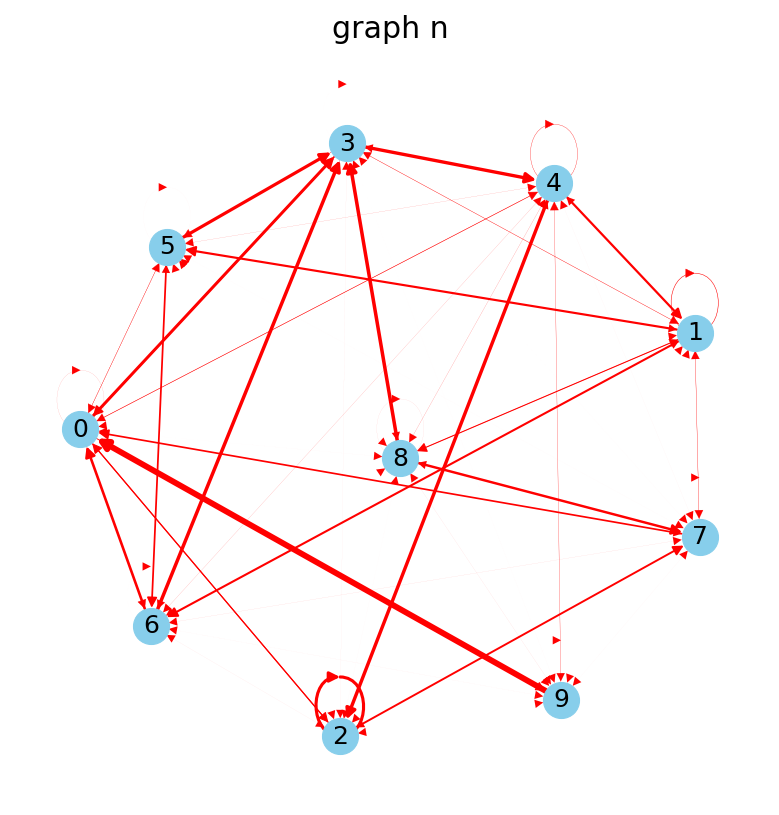

In [ ]:
np.random.seed(80)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800, rerun = 1)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

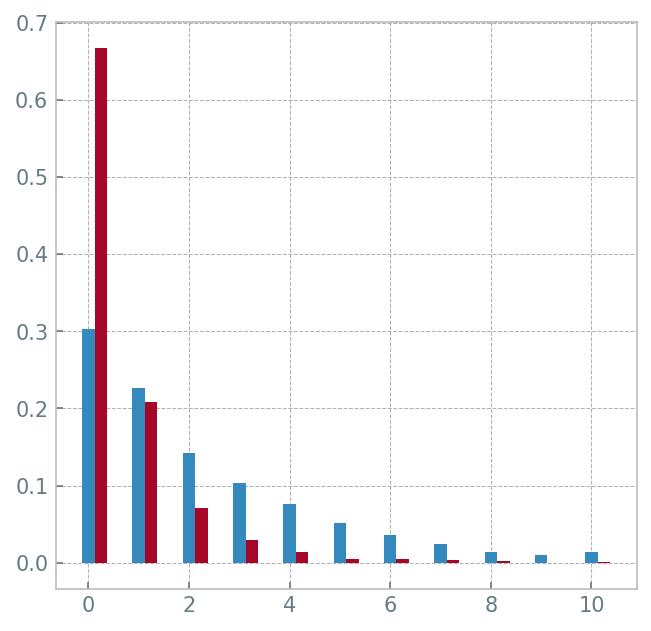

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.0066926

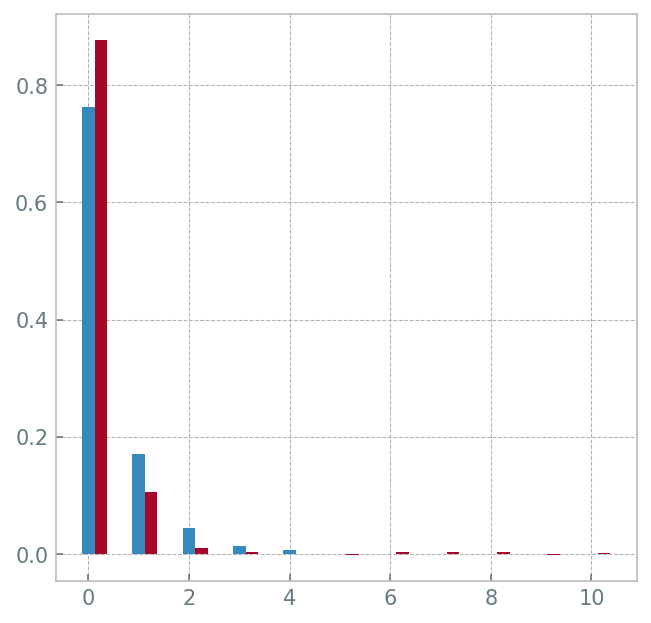

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

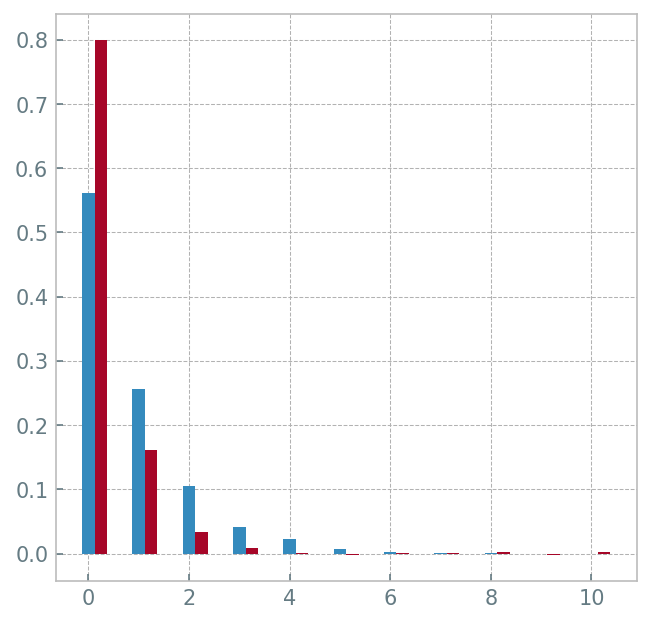

In [ ]:
#node 2
node = 4
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 3

0
tensor([100., 100., 100., 100.,   8., 100., 100.,   3.,   9., 100.],
       device='cuda:0')


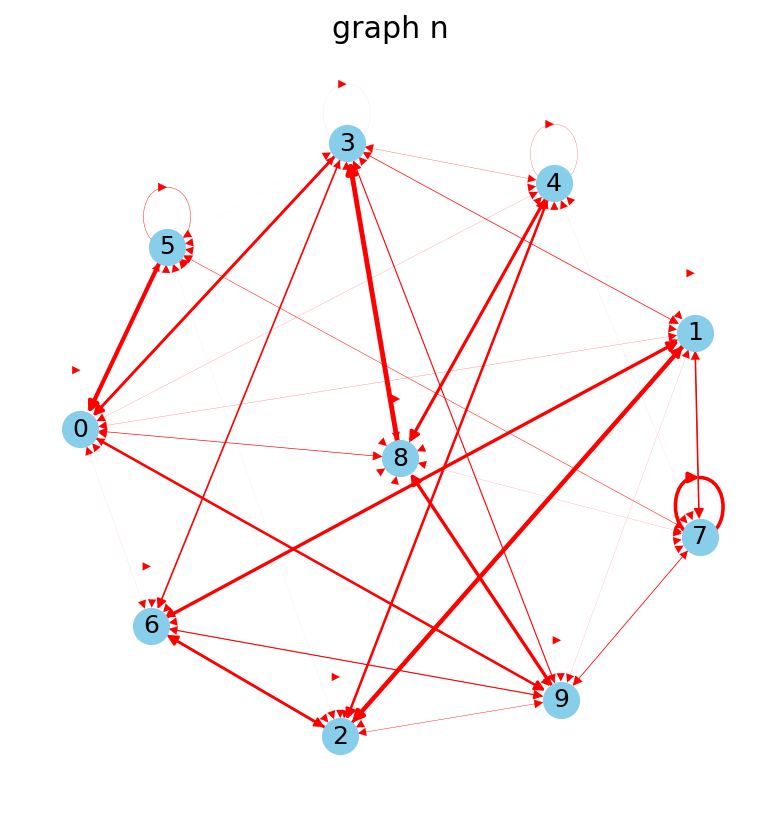

In [ ]:
np.random.seed(81)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800, rerun = 1)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

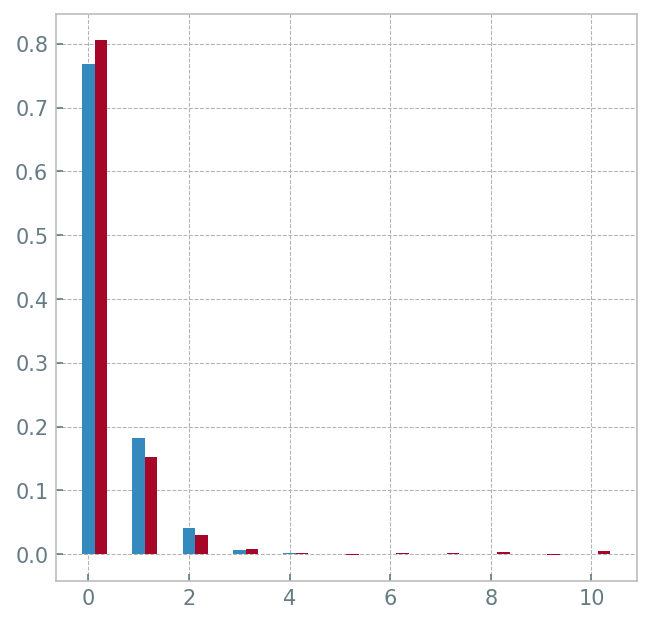

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.005579

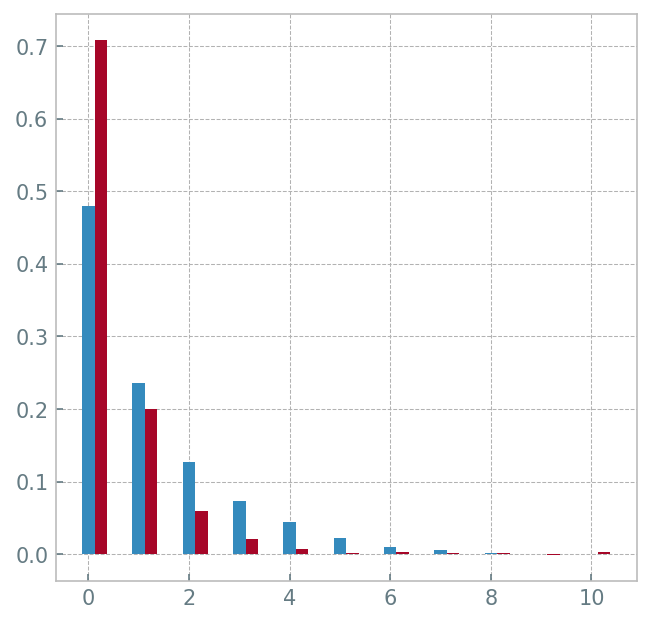

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

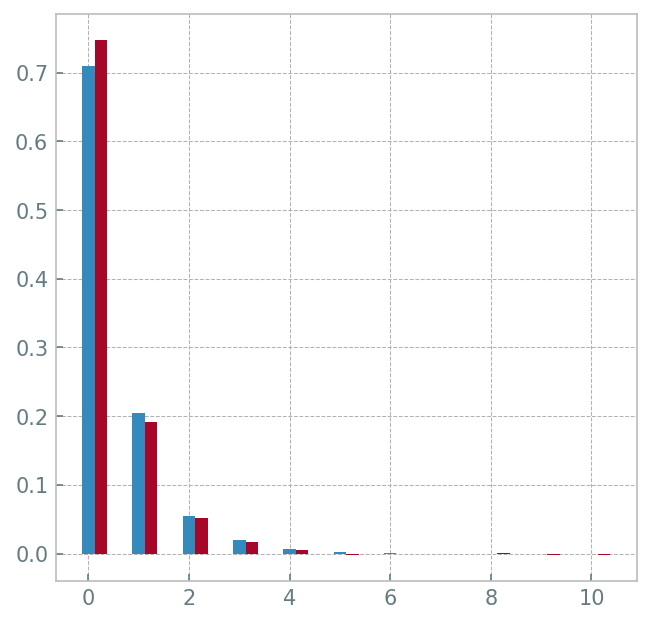

In [ ]:
#node 2
node = 3
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 4

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([100., 100., 100.,   5., 100., 100., 100., 100.,   8., 100.],
       device='cuda:0')


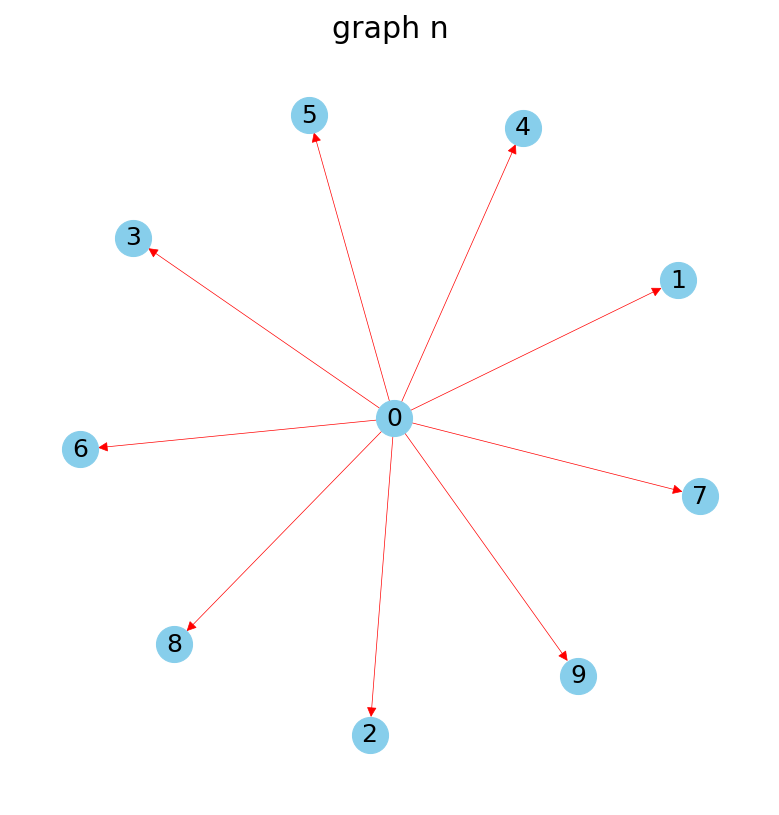

In [ ]:
np.random.seed(83)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

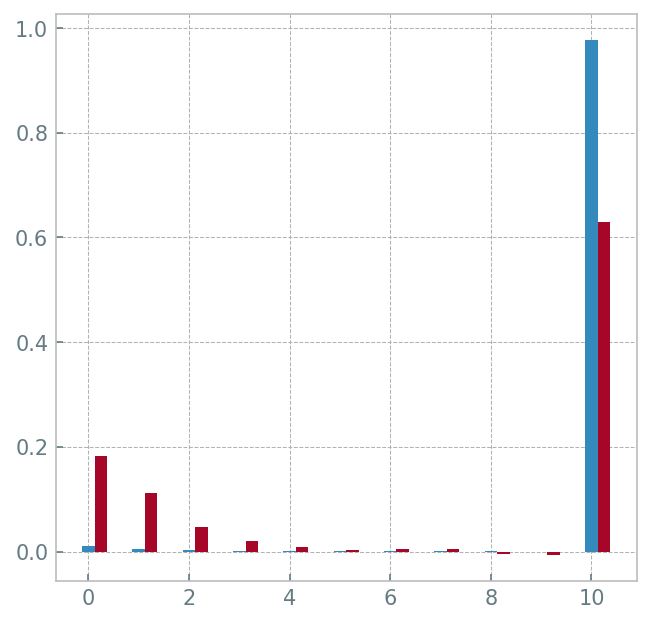

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.0061294

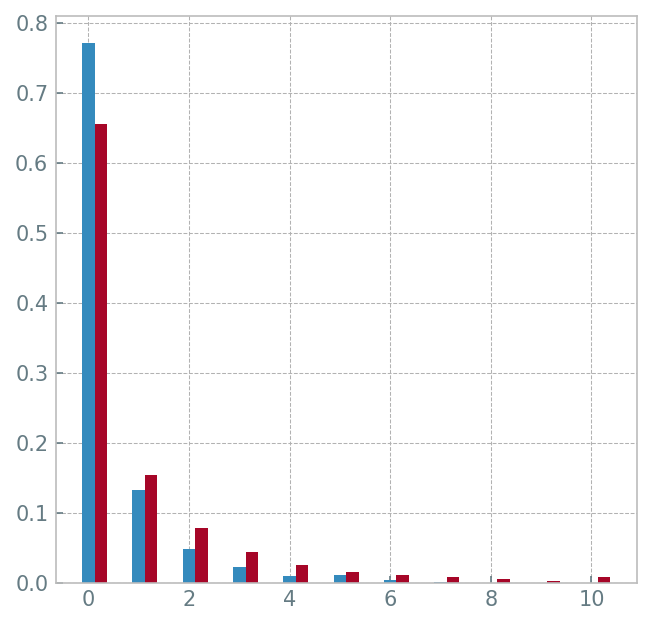

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

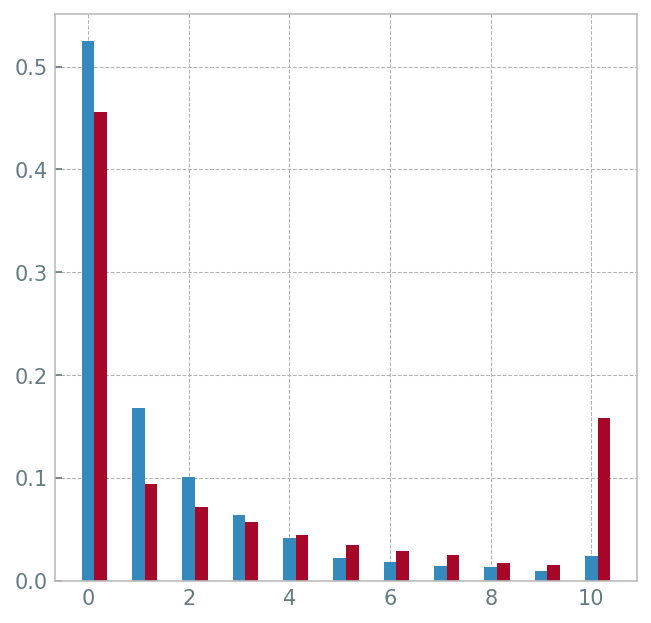

In [ ]:
#node 2
node = 4
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 5

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([100., 100., 100.,   5., 100.,   3., 100., 100.,   9., 100.],
       device='cuda:0')


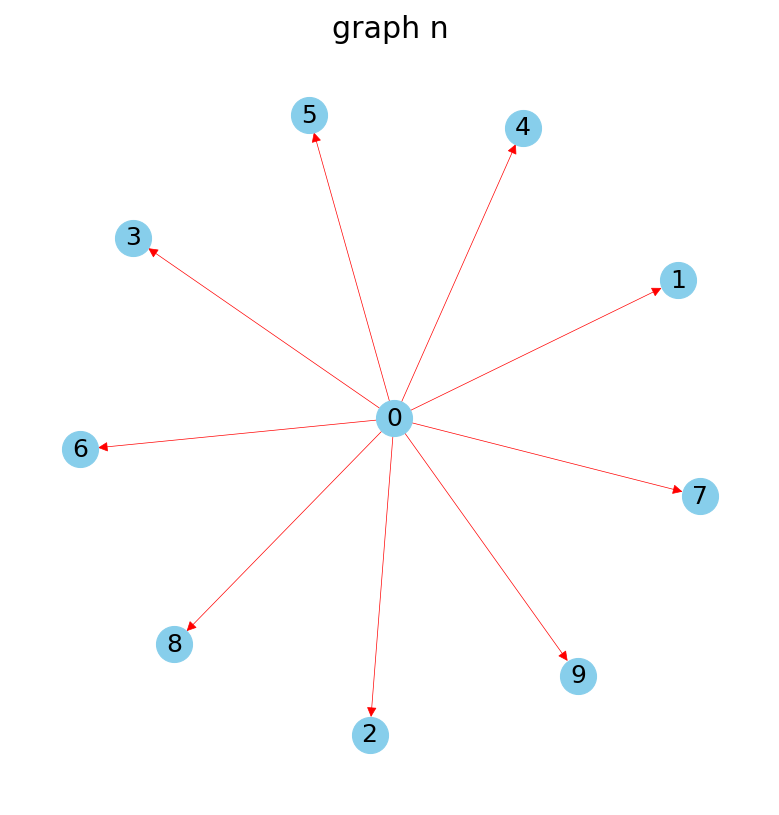

In [ ]:
np.random.seed(84)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

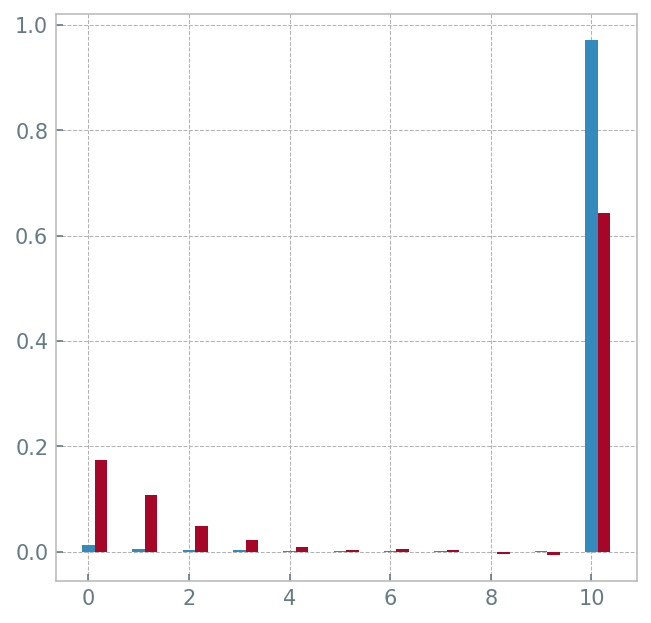

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.003647

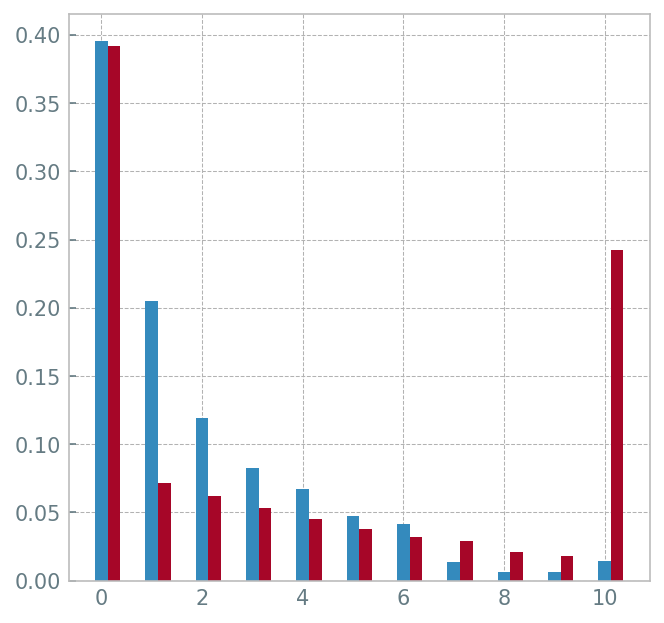

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

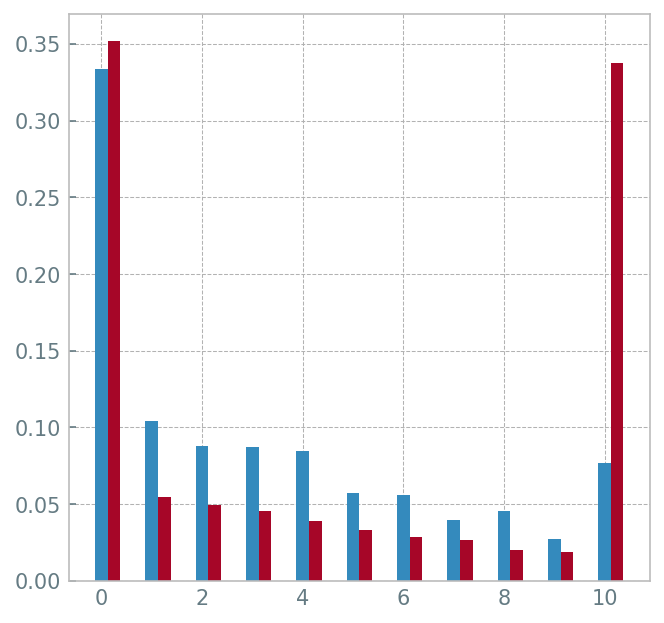

In [ ]:
#node 2
node = 4
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 6

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([  3.,   1., 100., 100., 100.,   4., 100.], device='cuda:0')


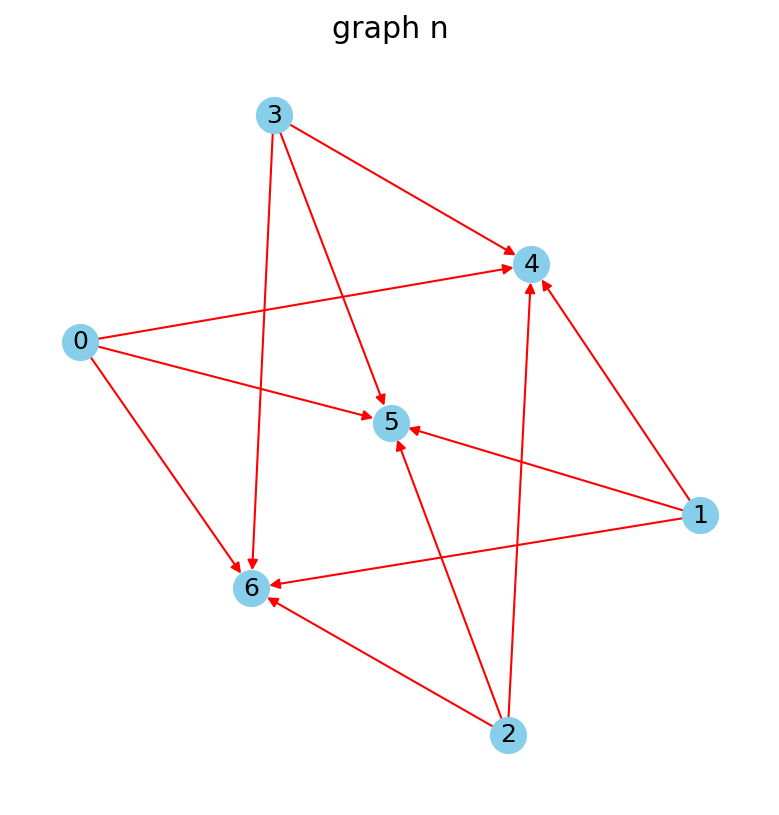

In [ ]:
np.random.seed(93)
num_nodes = 7
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

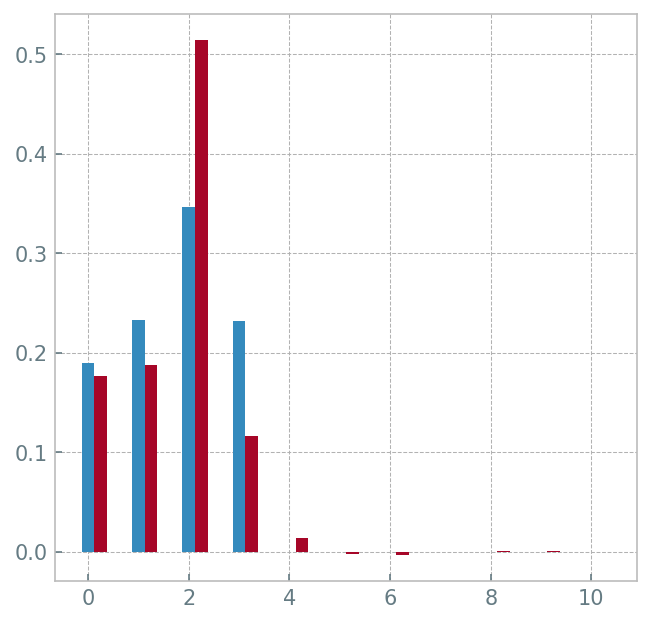

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.005618

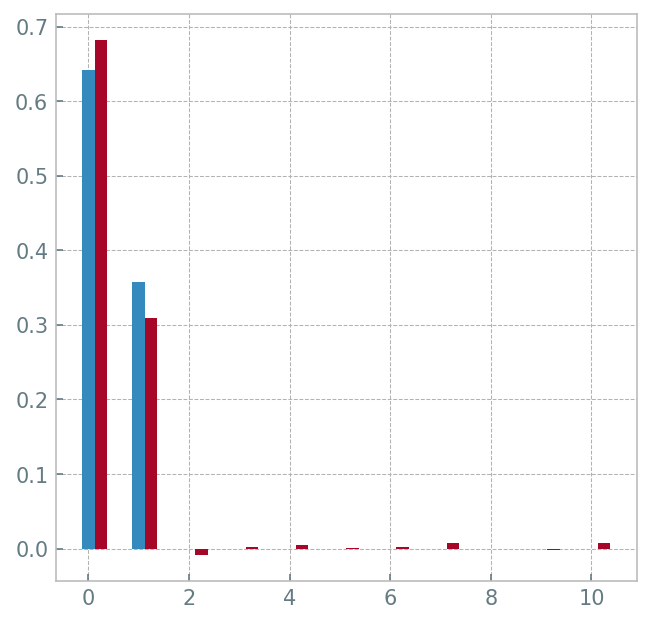

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

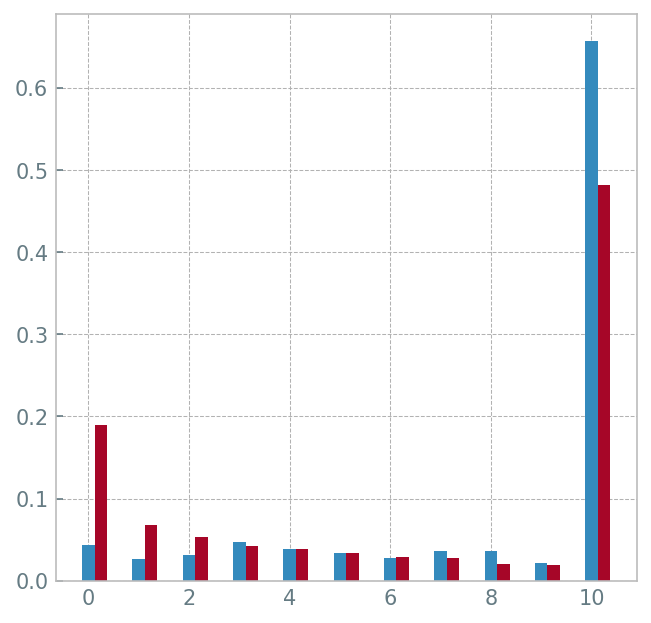

In [ ]:
#node 2
node = 4
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 7

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([  2., 100.,   5.,   8.,   9.,   6.,   6.,   7.,   5., 100.],
       device='cuda:0')


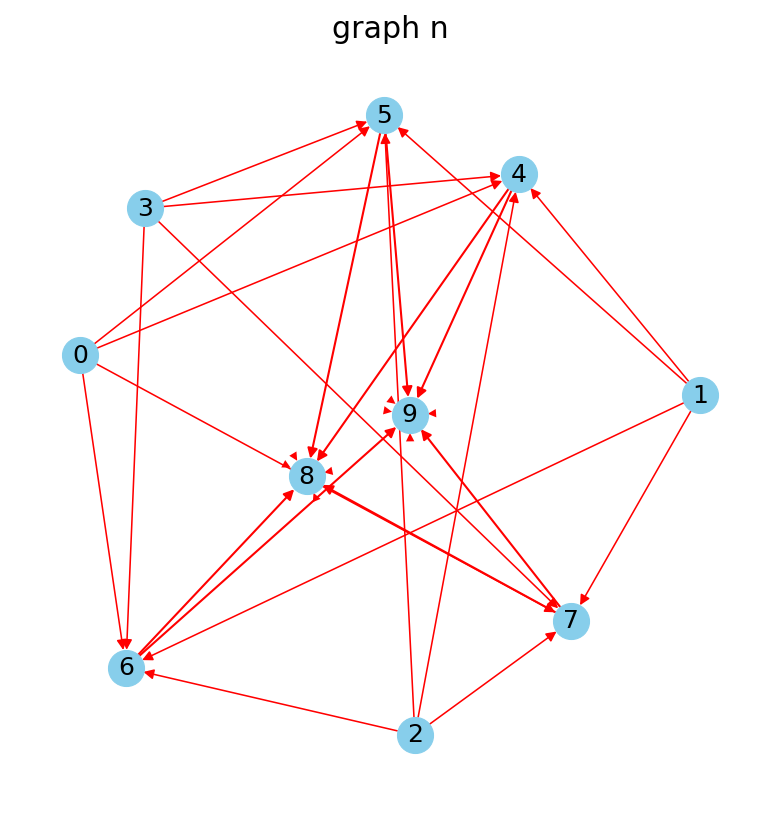

In [ ]:
np.random.seed(96)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

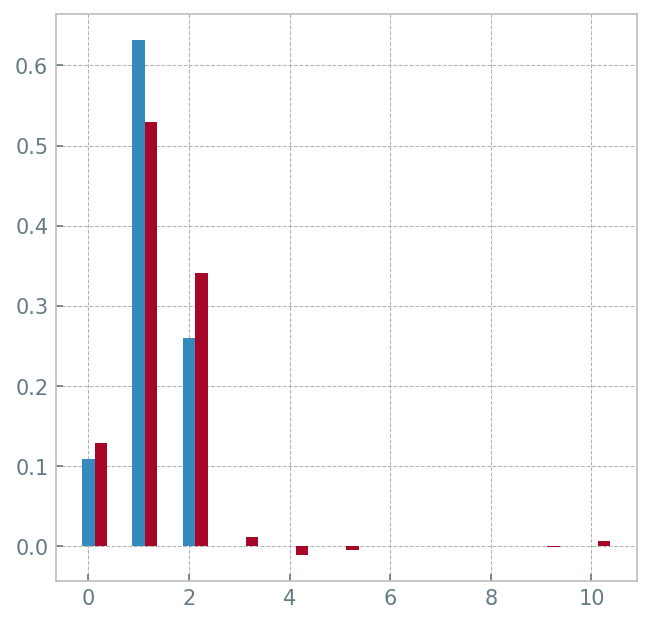

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.002333

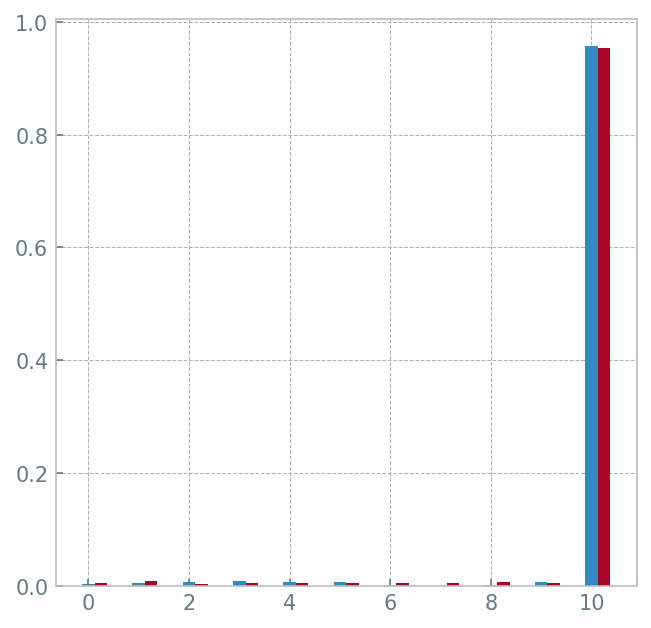

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

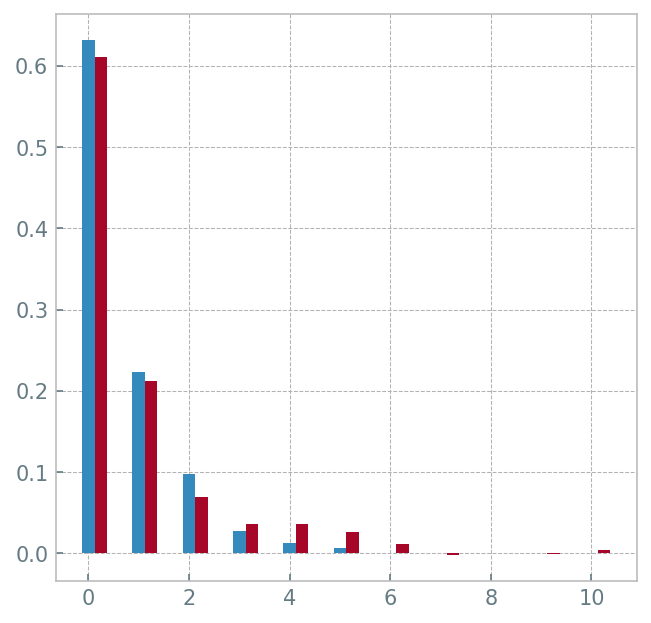

In [ ]:
#node 2
node = 8
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 8

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([  2., 100.,   5.,   8.,   9.,   6.,   6.,   7.,   5., 100.],
       device='cuda:0')


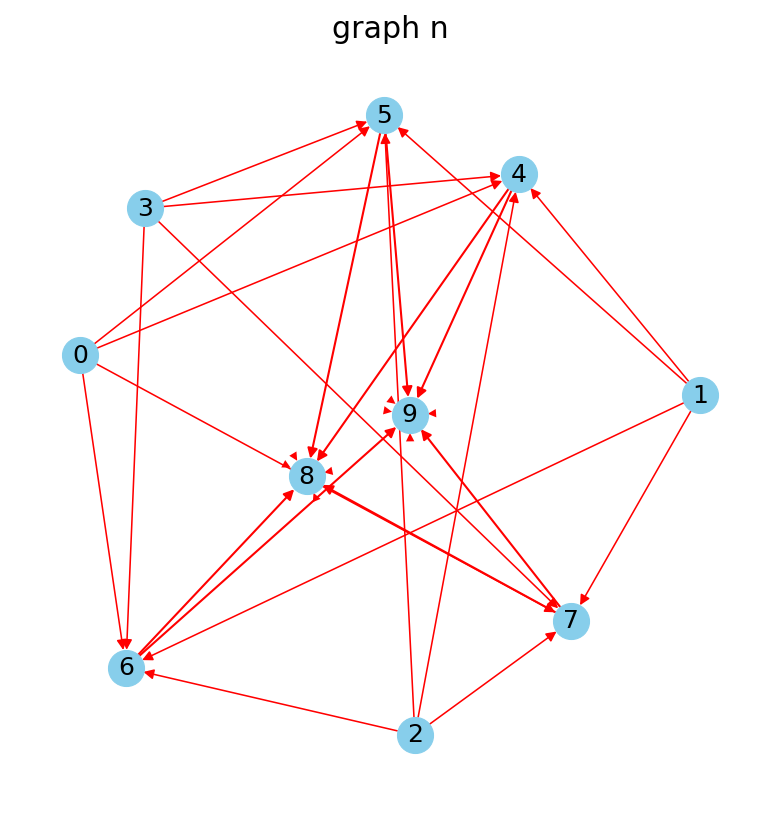

In [ ]:
np.random.seed(96)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

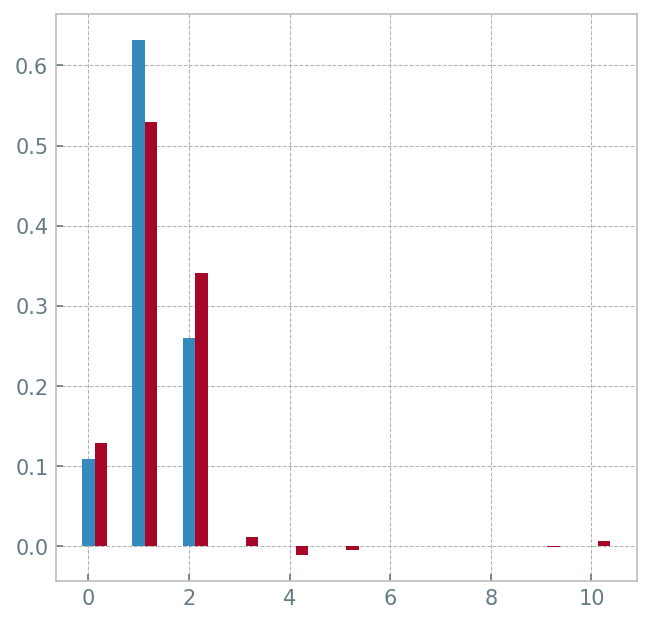

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.002333

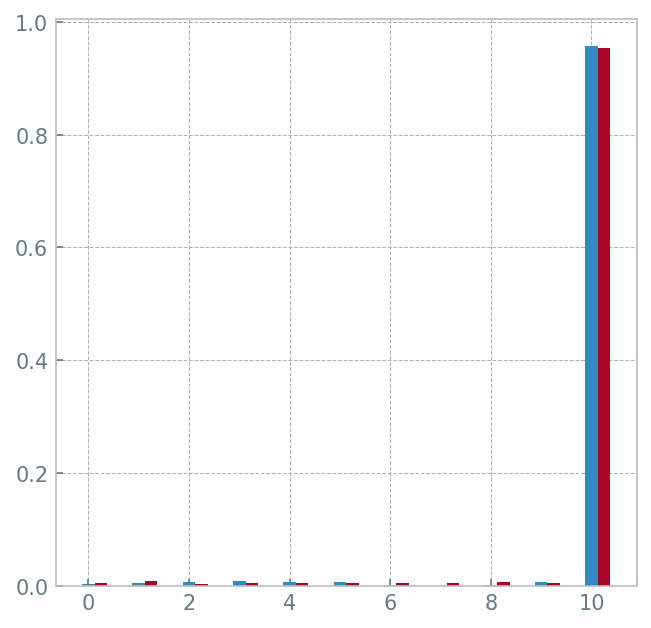

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

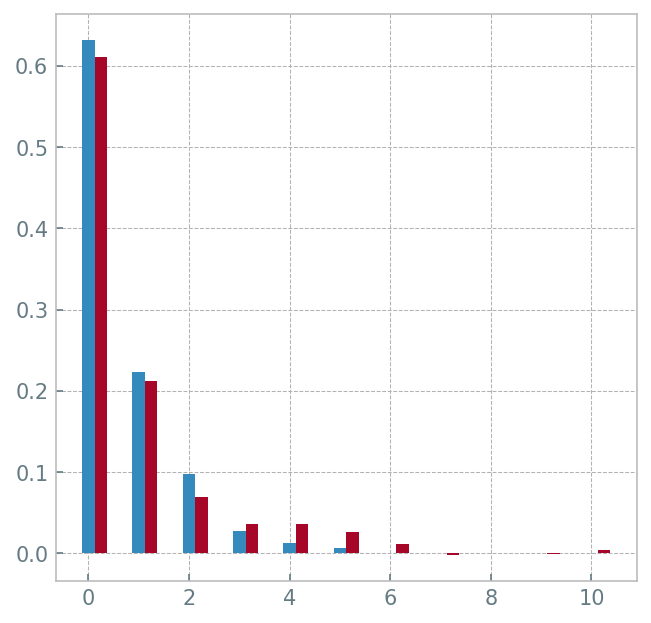

In [ ]:
#node 2
node = 8
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 9

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([  4.,   8.,   2.,   2.,   8.,   8.,   1., 100.,   4.,   3.],
       device='cuda:0')


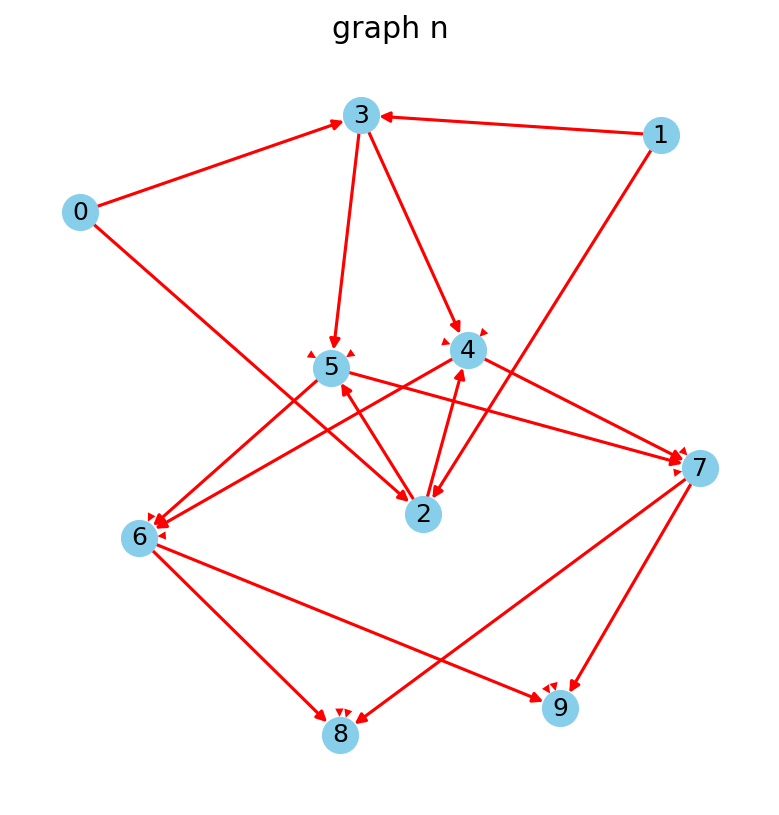

In [ ]:
np.random.seed(100)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

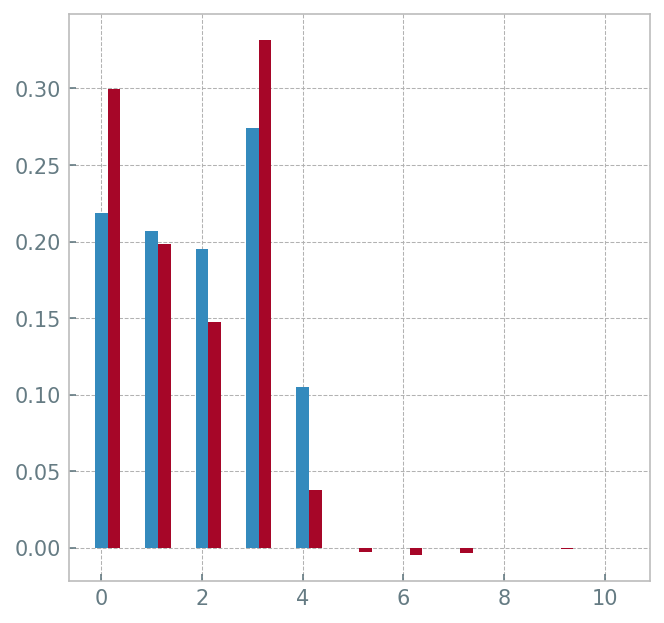

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.0005313

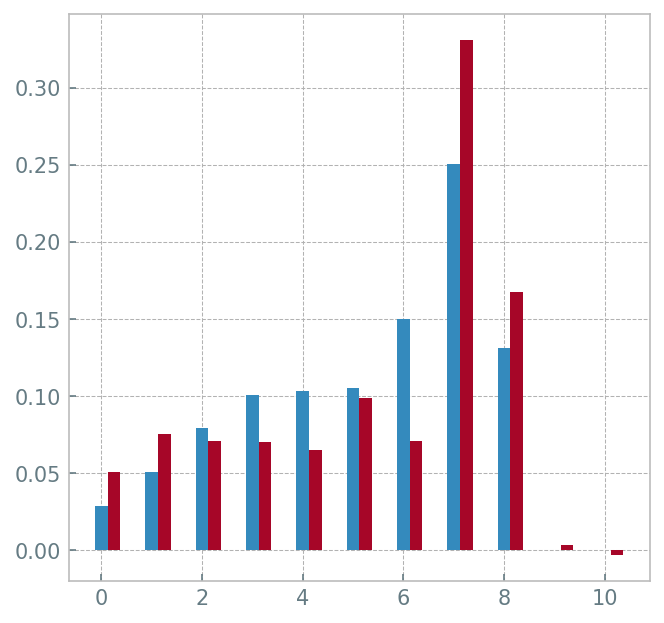

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

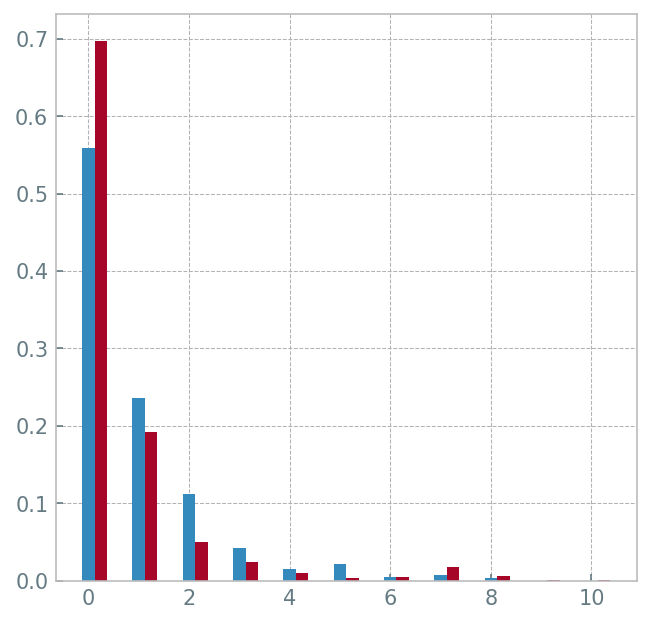

In [ ]:
#node 2
node = 5
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)

###graph example 10

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


tensor([  6.,   9.,   8.,   8.,   4.,   6.,   8.,   6., 100.,   2.],
       device='cuda:0')


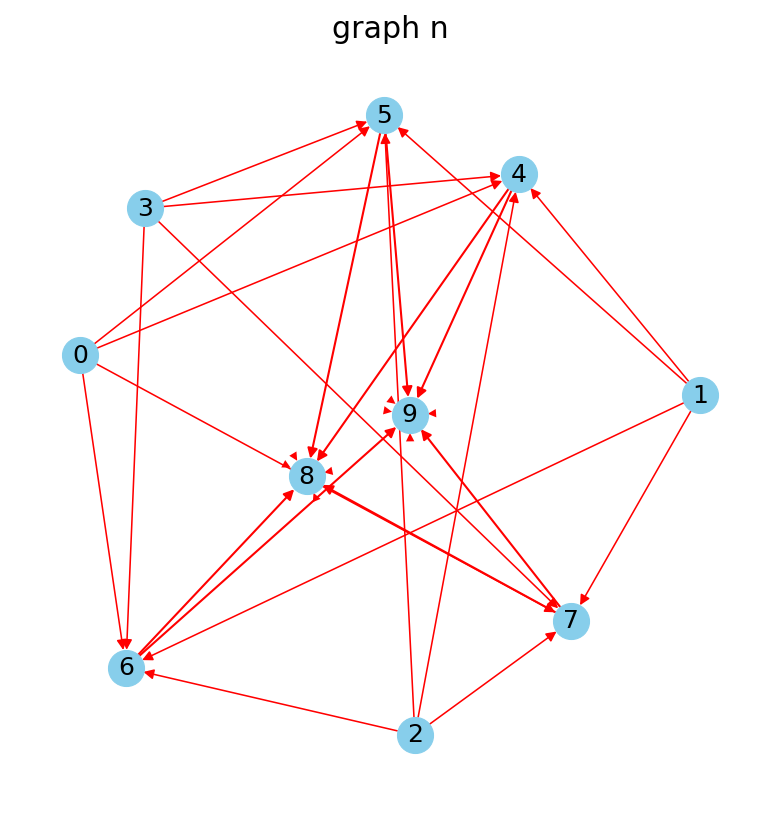

In [ ]:
np.random.seed(102)

num_nodes = 10
test_system = queue_graph_dataset(1,num_nodes,num_nodes+1, 800)#create 1 queue sim with 3 nodes

graph_list = []

for graph, label in test_system:
    draw(graph.cpu(), 'graph n')
    graph_list.append(graph)

test_graph = graph_list[0]

train_loader = DataLoader(test_system, batch_size=1, shuffle=False, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = next(iter(train_loader))

batch_X = batch_graphs.ndata['features']
batch_E = batch_graphs.edata['p_mat']

batch_features = batch_X.cpu().numpy()
buffers = batch_X[:,2]
print(buffers)

batch_scores = model(batch_graphs, batch_X, batch_E, batch_snorm_n, batch_snorm_e)

SSE = accuracy(batch_scores, batch_labels)
TSS = np.sum(batch_scores.cpu().detach().numpy()**2)

batch_labels = batch_labels.cpu().numpy().reshape(num_nodes,11)
batch_scores = batch_scores.cpu().detach().numpy().reshape(num_nodes,11)

<BarContainer object of 11 artists>

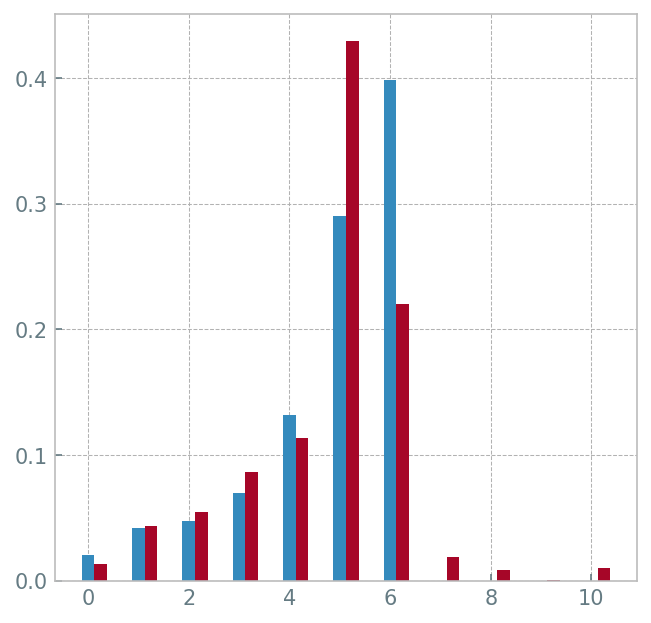

In [ ]:
#node 0
plt.bar(np.arange(11),batch_labels[0,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[0,:], width = .25)

1.0020225

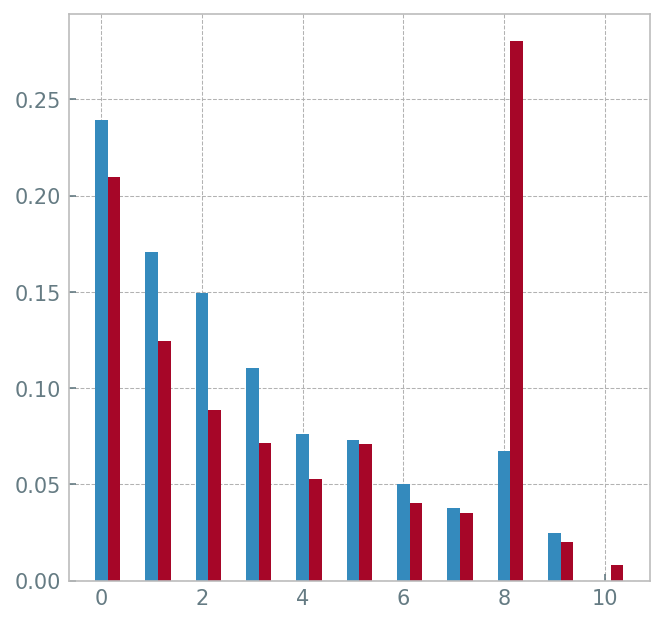

In [ ]:
#node 1
plt.bar(np.arange(11),batch_labels[1,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[1,:], width = .25)
np.sum(batch_scores[1,:])

<BarContainer object of 11 artists>

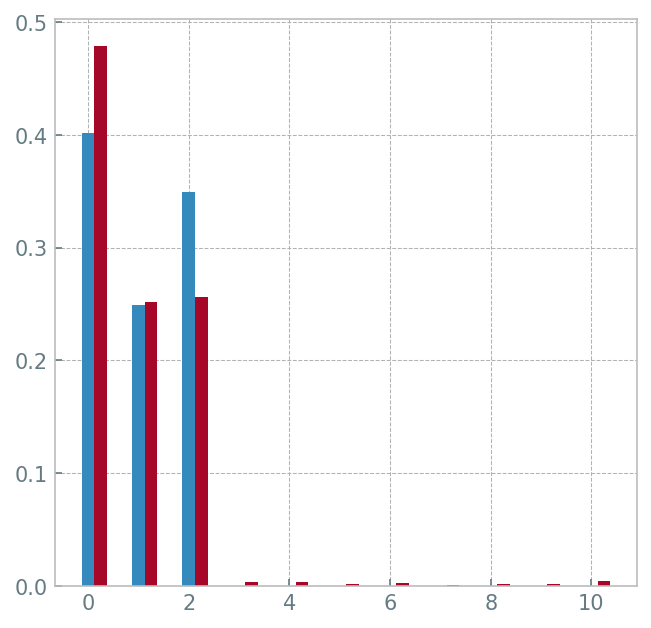

In [ ]:
#node 2
node = 9
plt.bar(np.arange(11),batch_labels[node,:], width = .25)
plt.bar(np.arange(11)+.25,batch_scores[node,:], width = .25)